# Film Slate Recommender — Actors, Directors, and Synergy

**What this does:** Given a brief (year, budget, genres, role), rank **actors** and **directors** by likelihood of a high-resonance outcome, and produce **explainable** shortlists with alternates. Optional **actor↔director synergy** nudges names who’ve historically worked well with a chosen director.

**Key ideas**
- **Temporal validation** to avoid leakage (train ≤ cutoff year; test > cutoff).
- **Signal features**: actor momentum (`atr3`), director exposure (`dtr3`), budget, release cadence, cyclic year encodings, genre affinities.
- **Explainability first**: permutation importance, ablations, per-row reason codes, alternates (nearest neighbors).
- **Product output**: ranked CSV slates + manifest + plots; Streamlit app for interactive exploration.

**Intended users:** development/greenlight teams who need **plausible, explainable** slates that respond to a brief.


In [46]:
import pandas as pd, numpy as np, os, shutil, json, joblib, re
from pathlib import Path
from typing import Sequence
import matplotlib.pyplot as plt
from datetime import datetime
from itertools import pairwise
import random 

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error,  average_precision_score, precision_recall_curve, brier_score_loss
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.calibration import CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance
from sklearn.base import clone

SEED = 42
np.random.seed(SEED); random.seed(SEED)

DATA_DIR = Path("/Cast_and_Crew/data")


# --- Project paths rooted to Cast_and_Crew ---
def find_project_root(target="Cast_and_Crew", max_up=7):
    p = Path.cwd().resolve()
    for _ in range(max_up+1):
        if p.name == target: return p
        q = p/target
        if q.exists() and q.is_dir(): return q
        p = p.parent
    return Path.cwd().resolve()

PROJECT_ROOT = find_project_root("Cast_and_Crew")
REPORTS_DIR  = PROJECT_ROOT / "reports"; REPORTS_DIR.mkdir(parents=True, exist_ok=True)
ARTIFACTS_DIR= PROJECT_ROOT / "artifacts"; ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

reports_dir, artifacts_dir = str(REPORTS_DIR), str(ARTIFACTS_DIR)
print("[paths]", PROJECT_ROOT)


TRAIN_CUTOFF_YEAR = 2003

MODEL_CSV = DATA_DIR/'fa_long_synth.csv'
df = pd.read_csv(MODEL_CSV)
print(df.shape); df.columns[:25]
genre_cols = [c for c in df.columns if c.startswith('genre_')]


[paths] D:\Cast_and_Crew
(1805, 17)


# Step: 1 
### Data & label
Rows are (film, actor) pairs with year, budget, release density, and genre flags.  
**Label**: “high resonance” = top quartile **within train era** only (prevents future leakage).


In [47]:
# --- DATA LOAD (synthetic demo or local real) ---
from pathlib import Path
import pandas as pd
import numpy as np

DEMO_MODE = True  # set False only if you have your own fa_long.csv locally

DATA_SYN  = Path("data/fa_long_synth.csv")
DATA_REAL = Path("data/fa_long.csv")  # ignored unless DEMO_MODE=False and file exists

DATA_PATH = DATA_SYN if DEMO_MODE or not DATA_REAL.exists() else DATA_REAL
print(f"[data] loading: {DATA_PATH}")

fa = pd.read_csv(DATA_PATH)

# Basic schema guard & dtypes
required = [
    'movie_title','movie_year','budget','bill_order',
    'actor_name','director_name','resonance','_ord'
]
missing = [c for c in required if c not in fa.columns]
assert not missing, f"Missing required columns: {missing}"

fa['movie_year'] = fa['movie_year'].astype(int)
fa['bill_order'] = fa['bill_order'].astype(int)
fa['budget']     = fa['budget'].astype(float)

# Genre column discovery
genre_cols = [c for c in fa.columns if c.startswith('genre_')]
assert len(genre_cols) >= 1, "Need at least one 'genre_*' column."

print(f"[data] loaded fa shape: {fa.shape} with {len(genre_cols)} genre flags")
fa.head(3)


[data] loading: data\fa_long_synth.csv
[data] loaded fa shape: (1805, 17) with 5 genre flags


,movie_title,movie_year,budget,bill_order,actor_name,director_name,resonance,genre_action,genre_drama,genre_comedy,genre_thriller,genre_romance,_ord,atr3,_dor,dtr3,release_density
0,Synth Movie 0315,1996,1.592773e+07,1,Actor_000,Director_55,51.646571,0,0,0,1,0,1,0.000000,1,0.000000,0.0
1,Synth Movie 0332,1999,3.109677e+07,2,Actor_000,Director_42,48.866339,0,1,0,0,0,2,51.646571,21,50.634167,1.0
2,Synth Movie 0347,2002,3.738831e+06,3,Actor_000,Director_07,35.187369,0,0,0,1,0,3,50.256455,27,51.198185,2.0



### A. Helper for trailing means (shifted + smoothed) and B. Core actor & director signals (ATR/DTR)

In [48]:
# 1
def trailing_mean_smooth(frame, group, val, time_col='_ord', n=3, k=2.0):
    g = frame.sort_values([group, time_col, 'bill_order']).copy()
    prior = g.groupby(group)[val].apply(lambda s: s.shift(1).rolling(n, min_periods=1).mean())
    g['__prior'] = prior.reset_index(level=0, drop=True)
    cnt = g.groupby(group).cumcount()
    mu = g[val].mean()
    g['__prior'] = g['__prior'].fillna(mu)
    return (cnt/(cnt+k))*g['__prior'] + (k/(cnt+k))*mu

# Actor Trailing Resonance (3-film, smoothed)

# 2
fa['atr3'] = trailing_mean_smooth(fa, 'actor_name', 'resonance')

# Director Trailing Resonance (graceful fallback if missing)
if 'director' in fa.columns:
    tmp = fa[['director','_ord','bill_order','resonance']].copy()
    tmp['dtr3'] = trailing_mean_smooth(tmp.rename(columns={'director':'_grp'}), '_grp', 'resonance')
    fa['dtr3'] = tmp['dtr3'].values
else:
    fa['dtr3'] = 0.0


### C. Budget fit, genre affinity, release density, MPAA fit

In [49]:
# Budget deciles per film
fa['budget_decile'] = pd.qcut(fa['budget'].fillna(fa['budget'].median()), 10, labels=False, duplicates='drop')

# Actor historic budget decile (trailing median over prior 3 roles)
tmp = (fa.sort_values(['actor_name','_ord','bill_order'])
         .groupby('actor_name')['budget_decile']
         .apply(lambda s: s.shift(1).rolling(3, min_periods=1).median()))
fa['actor_budget_decile_hist'] = tmp.reset_index(level=0, drop=True)
fa['bfd'] = (fa['budget_decile'] - fa['actor_budget_decile_hist']).abs().fillna(0)

# Genre affinity (rolling share over prior 5 roles)
for g in genre_cols:
    hist = (fa.sort_values(['actor_name','_ord','bill_order'])
              .groupby('actor_name')[g]
              .apply(lambda s: s.shift(1).rolling(5, min_periods=1).mean()))
    fa[f'{g}_aff'] = hist.reset_index(level=0, drop=True).fillna(0)

# Release density (roles count in trailing 3 entries)
fa['release_density'] = (fa.sort_values(['actor_name','_ord','bill_order'])
                           .groupby('actor_name')['_ord']
                           .transform(lambda s: s.shift(1).rolling(3, min_periods=1).count())
                           .fillna(0))

# MPAA fit vs actor's dominant historical MPAA
if 'mpaa' in fa.columns:
    dom = fa.groupby('actor_name')['mpaa'].agg(lambda s: s.dropna().mode().iloc[0] if s.dropna().size else np.nan)
    fa = fa.merge(dom.rename('actor_dom_mpaa'), on='actor_name', how='left')
    fa['mpaa_fit'] = (fa['mpaa'] == fa['actor_dom_mpaa']).astype(int).fillna(0)
else:
    fa['mpaa_fit'] = 0

# Step 3: ## Temporal split & Feature set

In [50]:

feature_cols = ['atr3','dtr3','bfd','release_density','year_sin','year_cos','bill_order'] \
               + [f'{g}_aff' for g in genre_cols] \
               + ([ 'budget' ] if 'budget' in fa.columns else [])
feature_cols = [c for c in feature_cols if c in fa.columns]

# Cyclical year features used by the cycle prior
span = (fa['movie_year'].max() - fa['movie_year'].min()) + 1.0
y0   = fa['movie_year'].min()
fa['year_sin'] = np.sin(2*np.pi*(fa['movie_year'] - y0)/span)
fa['year_cos'] = np.cos(2*np.pi*(fa['movie_year'] - y0)/span)


# Temporal split
train = fa[fa['movie_year'] <= 2003].copy()
test  = fa[fa['movie_year']  > 2003].copy()

# Label = top quartile resonance within each split
y_tr = (train['resonance'] >= train['resonance'].quantile(0.75)).astype(int)
y_te = (test['resonance']  >= test['resonance'].quantile(0.75)).astype(int)

X_tr = train[feature_cols].fillna(0)
X_te = test[feature_cols].fillna(0)

keep = X_tr.std() > 1e-6
X_tr, X_te = X_tr.loc[:, keep], X_te.loc[:, keep]
print("Kept features:", list(X_tr.columns))

for f in ['atr3','dtr3','bfd','release_density'] + [c for c in X_tr.columns if c.endswith('_aff')][:3]:
    if f in X_tr.columns:
        print(f, "uniques train/test:", X_tr[f].nunique(), X_te[f].nunique())

clf = LogisticRegression(max_iter=1000)
clf.fit(X_tr, y_tr)

# always grab the probability for the *positive* class robustly
pos_idx = list(clf.classes_).index(1)      # works even if classes_ is [1,0]
proba   = clf.predict_proba(X_te)[:, pos_idx]

# Use a single threshold defined on TRAIN and apply to both splits
cut = train['resonance'].quantile(0.75)
y_tr = (train['resonance'] >= cut).astype(int)
y_te = (test['resonance']  >= cut).astype(int)


auc = roc_auc_score(y_te, proba)
proba_fixed = 1 - proba if auc < 0.5 else proba
print("AUC:", round(auc,3), "| AUC (fixed if flipped):", round(roc_auc_score(y_te, proba_fixed), 3))



Kept features: ['atr3', 'bfd', 'release_density', 'bill_order', 'genre_action_aff', 'genre_drama_aff', 'genre_comedy_aff', 'genre_thriller_aff', 'genre_romance_aff', 'budget']
atr3 uniques train/test: 826 731
bfd uniques train/test: 18 16
release_density uniques train/test: 4 4
genre_action_aff uniques train/test: 11 11
genre_drama_aff uniques train/test: 11 11
genre_comedy_aff uniques train/test: 11 11
AUC: 0.768 | AUC (fixed if flipped): 0.768


#### A. Setting the temporal split


In [51]:
# --- Train cutoff & train-era budget bins ---
  # keeps consistentency with the temporal split

train_mask = fa['movie_year'] <= TRAIN_CUTOFF_YEAR
import numpy as np, pandas as pd

# Persist budget bin edges learned from TRAIN data only (stable at inference)
_, budget_bins_train = pd.qcut(
    fa.loc[train_mask, 'budget'].dropna(), 
    10, retbins=True, duplicates='drop'
)

def budget_to_decile_using_train_bins(budget: float) -> int:
    """Map a numeric budget to the train-era decile index [0..9] using fixed bins."""
    edges = budget_bins_train
    # Use interior cut points for np.digitize
    cuts = edges[1:-1] if len(edges) > 2 else edges
    idx = np.digitize([budget], cuts, right=True)[0]
    return int(idx)


#### B. Merging director names for synergy and director predictions based off of dtr3 and atr3

In [52]:
# ---- Attach director_name to fa by auto-joining from existing metadata ----
def attach_director_to_fa(fa: pd.DataFrame) -> pd.DataFrame:
    # candidate global DataFrames to search
    prefer_join_keys = ("movie_id","tconst","imdb_id","movie_title","title")
    director_name_aliases = ("director_name","director","dir_name","director_full_name")

    best = None
    # scan globals for DataFrames with a director column + a shared key with fa
    for name, obj in globals().items():
        if not isinstance(obj, pd.DataFrame):
            continue
        cols_lower = {c.lower(): c for c in obj.columns}
        # find a director-like column
        dcol = next((cols_lower[c] for c in cols_lower if "director" in c), None)
        if not dcol:
            continue
        # find a join key present in both
        key = next((k for k in prefer_join_keys if k in fa.columns and k in obj.columns), None)
        if not key:
            continue
        # build a minimal mapping and estimate coverage
        mapping = obj[[key, dcol]].dropna().drop_duplicates(subset=[key])
        coverage = mapping[key].isin(fa[key]).sum()
        if (best is None) or (coverage > best[3]):
            best = (name, mapping.rename(columns={dcol: "director_name"}), key, coverage)

    if best is None:
        raise RuntimeError(
            "Could not find a DataFrame with a director column and a shared join key.\n"
            "If you know your table, do it manually, e.g.:\n"
            "fa = fa.merge(titles[['movie_title','director_name']].drop_duplicates('movie_title'), on='movie_title', how='left')"
        )

    src_name, mapdf, key, cov = best
    print(f"[attach] using '{src_name}' on key '{key}' (coverage candidates: {cov})")
    fa2 = fa.merge(mapdf, on=key, how="left")
    missing = int(fa2['director_name'].isna().sum())
    print(f"[attach] 'director_name' missing after merge: {missing} rows")
    return fa2

# run the attach
# --- attach director_name (only if missing) ---

if 'director_name' in fa.columns and fa['director_name'].notna().any():
    print("[attach] 'director_name' already present; skipping attach.")
else:
    # your existing attach code goes here (merge from titles metadata)
    # make sure it creates a column literally named 'director_name'
    ...

    fa = attach_director_to_fa(fa)
    assert 'director_name' in fa.columns, "attach_director_to_fa failed to create 'director_name'"


[attach] 'director_name' already present; skipping attach.


#### C. Compute further actor aggregates for information density

In [53]:
# --- As-of-year actor aggregates (leakage-safe) ---
def compute_actor_aggregates_asof(fa_long: pd.DataFrame, as_of_year: int, window: int = 5) -> pd.DataFrame:
    """
    Returns per-actor trailing aggregates as of `as_of_year`:
      - actor_budget_decile_trailing: rolling median of budget deciles over prior roles
      - actor_release_density: rolling mean of release_density over prior roles
    """
    fa_up = fa_long.loc[fa_long['movie_year'] <= as_of_year].copy()

    # Map each row's budget to a TRAIN-era decile (fixed bins)
    fa_up['budget_decile'] = fa_up['budget'].apply(budget_to_decile_using_train_bins)

    # Sort within actor for proper trailing windows
    fa_up = fa_up.sort_values(['actor_name', '_ord'])

    # Trailing (shifted) windows prevent peeking at the current role
    fa_up['actor_budget_decile_trailing'] = (
        fa_up.groupby('actor_name')['budget_decile']
            .shift(1)
            .rolling(window, min_periods=1)
            .median()
    )
    fa_up['actor_release_density_trailing'] = (
        fa_up.groupby('actor_name')['release_density']
            .shift(1)
            .rolling(window, min_periods=1)
            .mean()
    )

    # Take the latest available trailing value per actor
    agg = fa_up.groupby('actor_name').agg(
        actor_budget_decile_trailing=('actor_budget_decile_trailing', 'last'),
        actor_release_density=('actor_release_density_trailing', 'last'),
    ).fillna(0)

    return agg


#### D. Define and train the director recommendation model

In [54]:
# === Director-side dataset & model ===
assert 'fa' in globals(), "Need the long table 'fa'."
assert 'TRAIN_CUTOFF_YEAR' in globals(), "Need TRAIN_CUTOFF_YEAR."
if 'director_name' not in fa.columns:
    raise ValueError("Your 'fa' is missing 'director_name'. Merge it from your titles metadata and re-run this cell.")

# Label: train-era 75th percentile threshold (same scheme as actors; no peeking)
cutoff = int(TRAIN_CUTOFF_YEAR)
is_tr  = fa['movie_year'] <= cutoff
th     = fa.loc[is_tr, 'resonance'].quantile(0.75)
y_all  = (fa['resonance'] >= th).astype(int)

# Build a *director-film* table: one row per (movie, director) with film-side features
film_cols       = ['movie_title','movie_year','budget','release_density']
genre_aff_cols  = [c for c in fa.columns if c.startswith('genre_') and c.endswith('_aff')]
dir_signal_cols = []  # keep this empty unless you have explicit director-only signals
# dtr3 in 'fa' is "director trailing 3y exposure *for that film*"; it should be constant per film.
# We'll take the first occurrence per (movie, director).
keep_cols = ['director_name'] + film_cols + genre_aff_cols + ['dtr3']  # dtr3 as a strong proxy
fd = (fa[keep_cols]
      .drop_duplicates(['movie_title','director_name'])
      .copy())

# Add cyclic time features
span = (fa['movie_year'].max() - fa['movie_year'].min()) + 1.0
fd['year_sin'] = np.sin(2*np.pi*(fd['movie_year'] - fa['movie_year'].min())/span)
fd['year_cos'] = np.cos(2*np.pi*(fd['movie_year'] - fa['movie_year'].min())/span)

# Label for these rows
fd = fd.merge(y_all.rename('y'), left_on=fa[['movie_title']].drop_duplicates().index, right_index=True, how='left')
# More robust: map movie_title -> y by first match in fa
m2y = fa[['movie_title']].assign(y=y_all.values).drop_duplicates('movie_title').set_index('movie_title')['y']
fd['y'] = fd['movie_title'].map(m2y).astype(int)

# Feature set for directors
dir_feature_cols = ['dtr3','budget','release_density','year_sin','year_cos'] + genre_aff_cols

# Train / test split by year
tr_mask = fd['movie_year'] <= cutoff
te_mask = fd['movie_year'] >  cutoff

X_tr, y_tr = fd.loc[tr_mask, dir_feature_cols].fillna(0), fd.loc[tr_mask, 'y']
X_te, y_te = fd.loc[te_mask, dir_feature_cols].fillna(0), fd.loc[te_mask, 'y']

# Model
dir_model = HistGradientBoostingClassifier(max_depth=None, learning_rate=0.08, max_iter=400, l2_regularization=0.0)
dir_model.fit(X_tr, y_tr)

# Eval
p_te = dir_model.predict_proba(X_te)[:,1]
auc  = roc_auc_score(y_te, p_te) if len(np.unique(y_te)) > 1 else float("nan")
print(f"[director] Holdout AUC: {auc:.3f} on {te_mask.sum()} rows")
print(f"[director] Features: {dir_feature_cols}")


[director] Holdout AUC: 0.696 on 165 rows
[director] Features: ['dtr3', 'budget', 'release_density', 'year_sin', 'year_cos', 'genre_action_aff', 'genre_drama_aff', 'genre_comedy_aff', 'genre_thriller_aff', 'genre_romance_aff']


### Actor model selection and training based on comparative results from HGB and RFC classifiers

In [55]:
feature_cols = ['atr3','dtr3','bfd','release_density','year_sin','year_cos','bill_order'] \
               + [f'{g}_aff' for g in genre_cols] \
               + ([ 'budget' ] if 'budget' in fa.columns else [])
feature_cols = [c for c in feature_cols if c in fa.columns]

# Temporal split
train = fa[fa['movie_year'] <= 2003].copy()
test  = fa[fa['movie_year']  > 2003].copy()

# Label = top quartile resonance within each split
y_tr = (train['resonance'] >= train['resonance'].quantile(0.75)).astype(int)
y_te = (test['resonance']  >= test['resonance'].quantile(0.75)).astype(int)

X_tr = train[feature_cols].fillna(0)
X_te = test[feature_cols].fillna(0)

keep = X_tr.std() > 1e-6
for c in ['dtr3','year_sin','year_cos']:
    if c in X_tr.columns: keep[c] = True
X_tr, X_te = X_tr.loc[:, keep], X_te.loc[:, keep]
print("Kept features:", list(X_tr.columns))

for f in ['atr3','dtr3','bfd','release_density'] + [c for c in X_tr.columns if c.endswith('_aff')][:3]:
    if f in X_tr.columns:
        print(f, "uniques train/test:", X_tr[f].nunique(), X_te[f].nunique())


# Tree #1: fast + strong
gbc = HistGradientBoostingClassifier(max_iter=400, learning_rate=0.08, random_state=42)
gbc.fit(X_tr, y_tr)
pred_gbc = gbc.predict_proba(X_te)[:, 1]
auc_gbc = roc_auc_score(y_te, pred_gbc)
print("HGB AUC:", round(auc_gbc, 3))

# Tree #2 (fallback if needed)
rf = RandomForestClassifier(n_estimators=400, min_samples_leaf=5, n_jobs=-1, random_state=42)
rf.fit(X_tr, y_tr)
pred_rf = rf.predict_proba(X_te)[:, 1]
auc_rf = roc_auc_score(y_te, pred_rf)
print("RF  AUC:", round(auc_rf, 3))

# pick a model to use downstream (choose the better AUC)
use_model = gbc if auc_gbc >= auc_rf else rf

# Decide if we need to flip scores globally based on validation
pred_val = pred_gbc if use_model is gbc else pred_rf
FLIP = roc_auc_score(y_te, pred_val) < 0.5
print("Use:", "HGB" if use_model is gbc else "RF", "| Flip:", FLIP)

Kept features: ['atr3', 'dtr3', 'bfd', 'release_density', 'year_sin', 'year_cos', 'bill_order', 'genre_action_aff', 'genre_drama_aff', 'genre_comedy_aff', 'genre_thriller_aff', 'genre_romance_aff', 'budget']
atr3 uniques train/test: 826 731
dtr3 uniques train/test: 1 1
bfd uniques train/test: 18 16
release_density uniques train/test: 4 4
genre_action_aff uniques train/test: 11 11
genre_drama_aff uniques train/test: 11 11
genre_comedy_aff uniques train/test: 11 11
HGB AUC: 0.69
RF  AUC: 0.794
Use: RF | Flip: False


In [56]:
# --- 3.5 Calibration utilities (display only; ranking stays base model) ---
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibratedClassifierCV
import numpy as np
import pandas as pd

# Temporal calibration slice from TRAIN years (e.g., last 20% by year)
q80 = train['movie_year'].quantile(0.8)
cal_mask = train['movie_year'] >= q80

# Align y to train's index so masks work (y_tr is a numpy array)
y_tr_series = pd.Series(y_tr, index=train.index)

X_cal = X_tr.loc[cal_mask]
y_cal = y_tr_series.loc[cal_mask].values

# 1) Platt (sigmoid) on FEATURES via cv='prefit'
PLATT_CAL = CalibratedClassifierCV(use_model, method='sigmoid', cv='prefit')
PLATT_CAL.fit(X_cal, y_cal)
print("[cal] PLATT_CAL fitted on temporal slice:",
      sorted(train.loc[cal_mask, 'movie_year'].unique()))

# 2) Isotonic on BASE PROBS (1-D mapping p_base -> p_cal)
p_base_cal = use_model.predict_proba(X_cal)[:, 1]
ISO_CAL = IsotonicRegression(out_of_bounds='clip')
ISO_CAL.fit(p_base_cal, y_cal)
print("[cal] ISO_CAL fitted on same slice")

def apply_calibration_probs(p_base: np.ndarray) -> np.ndarray:
    """Map base probs -> calibrated probs via isotonic (1-D). Safe clipped output."""
    p = np.asarray(p_base, dtype=float).ravel()
    p = ISO_CAL.predict(p)
    return np.clip(p, 1e-6, 1-1e-6)


[cal] PLATT_CAL fitted on temporal slice: [np.int64(2002), np.int64(2003)]
[cal] ISO_CAL fitted on same slice


c:\Users\bzach\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


In [57]:
# --- 3.6 Cycle prior (era uplift) and applicator ---
def fit_cycle_head_from_train(X_tr: pd.DataFrame, y_tr: np.ndarray, model) -> LinearRegression:
    """
    Learn a year-level residual pattern on TRAIN:
        r = y - p_base(X)
    Fit r ~ [year_sin, year_cos] using only train rows.
    Assumes year_sin/year_cos are present in X_tr (they are in feature_cols).
    """
    p = model.predict_proba(X_tr)[:, 1]
    r = y_tr.astype(float) - p
    Z = X_tr[['year_sin', 'year_cos']].values
    reg = LinearRegression().fit(Z, r)
    return reg

# Fit once on TRAIN
cycle_head = fit_cycle_head_from_train(X_tr, y_tr, use_model)
print("[cycle] fitted residual uplift on TRAIN years")

def apply_cycle_to_candidates(cand: pd.DataFrame, year: int, alpha: float = 0.7) -> np.ndarray:
    """
    Blend base probs with a year-specific uplift in logit space:
      logit(p̂) = (1-α)·logit(p_base) + α·logit(clip(p_base + uplift))
    Returns adjusted probabilities (1-D).
    """
    # predict uplift for the target year using the same span as training
    span = (fa['movie_year'].max() - fa['movie_year'].min()) + 1.0
    ysin = np.sin(2*np.pi*(year - fa['movie_year'].min())/span)
    ycos = np.cos(2*np.pi*(year - fa['movie_year'].min())/span)
    uplift = float(cycle_head.predict(np.array([[ysin, ycos]])))

    # start from base probs on the candidate slate
    p = cand["p_rank"].values if "p_rank" in cand.columns else cand.get("p_base", cand["p_high"]).values
    p = np.clip(p, 1e-6, 1-1e-6)

    # simple uplift in prob-space then blend in logit space
    p_u = np.clip(p + uplift, 1e-6, 1-1e-6)
    logit   = np.log(p/(1-p))
    logit_u = np.log(p_u/(1-p_u))
    adj = (1 - alpha) * logit + alpha * logit_u
    return 1 / (1 + np.exp(-adj))


[cycle] fitted residual uplift on TRAIN years


## Top-N cast for a profile + “unsung” alternates

### With larger and more complex talent databases and psychological profiles, this process will become increasingly precise.

In [58]:


model = use_model

# Columns the model was trained on (feature contract)
expected = list(getattr(model, "feature_names_in_", feature_cols))

# Build X in the exact order, fill any missing with 0.0
X = candidates.reindex(columns=expected, fill_value=0.0)

# Pick the positive class column robustly
pos_idx = 1
if hasattr(model, "classes_"):
    classes = list(model.classes_)
    if 1 in classes:
        pos_idx = classes.index(1)
    elif len(classes) == 2:
        pos_idx = classes.index(max(classes))

candidates["p_high"] = model.predict_proba(X)[:, pos_idx]
top = candidates.sort_values("p_high", ascending=False)[
    ["movie_title","actor_name","bill_order","p_high"]
].head(15)
top


,movie_title,actor_name,bill_order,p_high
1133,Synth Movie 0003,Actor_154,2,0.611640
1207,Synth Movie 0003,Actor_165,1,0.599667
737,Synth Movie 0003,Actor_100,3,0.527803
1728,Synth Movie 0368,Actor_238,4,0.457235
1674,Synth Movie 0197,Actor_230,2,0.444283
1059,Synth Movie 0343,Actor_143,4,0.440947
114,Synth Movie 0052,Actor_013,1,0.439932
952,Synth Movie 0197,Actor_129,1,0.438674
5,Synth Movie 0052,Actor_000,2,0.434889
115,Synth Movie 0191,Actor_013,1,0.429039


# Step 4. Dual Recommender Buildout

## This is the pivot from training to serving/recommending. It builds a train-serve aligned candidate matrix for actors at a chosen brief (year/budget/bill order), using leakage-safe “as-of” aggregates. 

In [59]:
# --- Candidate matrix builder (train-serve aligned) ---
def compute_actor_stable_means_asof(fa_long: pd.DataFrame, as_of_year: int, stable_feats) -> pd.DataFrame:
    """Leakage-safe actor means of stable features up to `as_of_year`."""
    cols = ['actor_name'] + stable_feats
    fa_up = fa_long.loc[fa_long['movie_year'] <= as_of_year, cols].replace([np.inf, -np.inf], np.nan).dropna()
    return fa_up.groupby('actor_name')[stable_feats].mean()

def build_candidate_matrix(
    fa_long: pd.DataFrame,
    as_of_year: int,
    film_budget: float,
    bill_order: int,
    feature_cols: list,
    stable_feats: list
) -> pd.DataFrame:
    """
    Returns a dataframe with ALL columns in `feature_cols`,
    constructed leakage-safely for the film year and aligned with training.
    """
    # 1) Actor-side: stable means (atr3, dtr3, genre_*_aff) as-of-year
    actor_means = compute_actor_stable_means_asof(fa_long, as_of_year, stable_feats)

    # 2) Actor-side: trailing aggregates for BFD & release_density as-of-year
    actor_aggs = compute_actor_aggregates_asof(fa_long, as_of_year, window=5)

    # 3) Merge actor features
    cand = actor_means.join(actor_aggs, how='left').fillna(0).copy()

    # 4) Film-side: time, budget, bill_order
    span = (fa_long['movie_year'].max() - fa_long['movie_year'].min()) + 1.0
    year_sin = np.sin(2*np.pi*(as_of_year - fa_long['movie_year'].min())/span)
    year_cos = np.cos(2*np.pi*(as_of_year - fa_long['movie_year'].min())/span)

    cand['year_sin'] = year_sin
    cand['year_cos'] = year_cos
    cand['budget']   = film_budget
    cand['bill_order'] = bill_order  # film-specific role seniority

    # 5) BFD & release_density (serve-time derivations)
    cand['film_budget_decile'] = budget_to_decile_using_train_bins(film_budget)
    cand['bfd'] = (cand['film_budget_decile'] - cand['actor_budget_decile_trailing']).abs()
    cand['release_density'] = cand['actor_release_density']

    # 6) Ensure all training features exist and are ordered
    for c in feature_cols:
        if c not in cand.columns:
            cand[c] = 0.0

    cand = cand.reset_index().rename(columns={'index':'actor_name'})
    return cand

# This should match how you built actor_feat earlier:
stable_feats = ['atr3', 'dtr3', 'bill_order'] + [c for c in fa.columns if c.startswith('genre_') and c.endswith('_aff')]



#### Utility -- Guard Function for ensuring clean DataFrames

In [60]:
"""
    Aligns `frame` to training schema and returns positive-class probabilities.

    - Ensures every column in `feature_cols` exists (adds zeros if missing)
    - Orders columns exactly as in `feature_cols`
    - Picks the correct probability column based on model.classes_
    - Optionally flips probs if validation indicated inversion
    """

def predict_proba_aligned(
    model,
    frame: pd.DataFrame,
    feature_cols,
    flip: bool = False,
    positive_label=1,
) -> np.ndarray:
    """
    Aligns input to the model's training schema and returns positive-class probabilities.
    - Uses model.feature_names_in_ if available; otherwise falls back to feature_cols.
    - Drops unexpected columns; fills missing with 0.0.
    """
    # Determine expected feature order from the fitted model
    expected = list(getattr(model, "feature_names_in_", feature_cols))

    # Build X with exact expected columns, in order
    X = frame.reindex(columns=expected, fill_value=0.0).astype(float)

    # Pick positive class column robustly
    pos_idx = 1
    if hasattr(model, "classes_"):
        classes = list(model.classes_)
        if positive_label in classes:
            pos_idx = classes.index(positive_label)
        elif len(classes) == 2:
            try:
                pos_idx = classes.index(max(classes))
            except Exception:
                pos_idx = 1

    # Get probabilities (fallback to decision_function if needed)
    if hasattr(model, "predict_proba"):
        p = model.predict_proba(X)[:, pos_idx]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X)
        p = 1.0 / (1.0 + np.exp(-scores))
    else:
        raise AttributeError("Model has neither predict_proba nor decision_function.")

    return 1 - p if flip else p



In [61]:
# ---- Build actor-level feature base from ALL rows (unsupervised aggregation) ----
aff_cols = [c for c in fa.columns if c.endswith('_aff')]
stable_feats = ['atr3','dtr3','bill_order','release_density'] + aff_cols

actor_feat = (
    fa.groupby('actor_name')[stable_feats].mean()
      .replace([np.inf, -np.inf], np.nan)
      .dropna()
)

# keep an actor-level estimate of historical budget decile to recompute bfd per film
if 'actor_budget_decile_hist' in fa.columns:
    actor_budget_hist = fa.groupby('actor_name')['actor_budget_decile_hist'].median()
else:
    # fallback: derive from past budget_decile if needed
    actor_budget_hist = fa.groupby('actor_name')['budget_decile'].median()

actor_feat = actor_feat.join(actor_budget_hist.rename('actor_budget_decile_hist'))

# Neighbors for "unsung" alternates (ALL data = fine; unsupervised)
nn = NearestNeighbors(n_neighbors=min(6, len(actor_feat)), metric='cosine').fit(actor_feat[stable_feats].values)
def unsung_alternates(actor, k=3):
    if actor not in actor_feat.index: return []
    idx = actor_feat.index.get_loc(actor)
    dist, ind = nn.kneighbors(actor_feat[stable_feats].iloc[[idx]].values, n_neighbors=min(k+1, len(actor_feat)))
    return [actor_feat.index[i] for i in ind[0] if actor_feat.index[i] != actor][:k]

# Precompute budget decile edges from historical data
budget_series = fa['budget'].dropna().astype(float)
edges = np.quantile(budget_series, np.linspace(0,1,11)) if len(budget_series) else np.linspace(0, 1, 11)

def budget_to_decile(x):
    return int(np.clip(np.searchsorted(edges, x, side='right') - 1, 0, 9))

# Map year -> sin/cos on same scale used in training
year_min, year_max = fa['movie_year'].min(), fa['movie_year'].max()
span = (year_max - year_min) + 1.0
def year_to_sincos(y):
    return (np.sin(2*np.pi*(y - year_min)/span), np.cos(2*np.pi*(y - year_min)/span))

def recommend_cast(year:int, budget:float, genres:list, bill_order:int=1, top_n:int=15,
                   *, calibrate:bool=True, use_cycle:bool=False, alpha:float|None=None):
    cand = build_candidate_matrix(
        fa_long=fa, as_of_year=year, film_budget=budget, bill_order=bill_order,
        feature_cols=feature_cols, stable_feats=stable_feats
    )

    # base model prob
    p_base = predict_proba_aligned(
        use_model, cand, feature_cols, flip=bool(globals().get("FLIP", False)), positive_label=1
    )
    cand["p_base"] = p_base

    # calibrated (DISPLAY ONLY)
    if calibrate and 'apply_calibration_probs' in globals():
        p_cal = apply_calibration_probs(p_base)
        # if isotonic collapses the slice, fall back to platt/identity for display
        if (np.std(p_cal) < 1e-3) or (len(np.unique(np.round(p_cal, 4))) < 5):
            if 'PLATT_CAL' in globals():
                p_cal = np.clip(PLATT_CAL.predict_proba(p_base.reshape(-1,1))[:,1], 1e-6, 1-1e-6)
            else:
                p_cal = p_base
        cand["p_cal"] = p_cal
    else:
        cand["p_cal"] = p_base

    # ranking score (DO NOT USE p_cal)
    p_rank = p_base.copy()
    if use_cycle and 'cycle_head' in globals():
        tmp = cand.copy()
        tmp["p_high"] = p_rank  # cycle expects this column name
        a = float(alpha) if alpha is not None else float(globals().get("ALPHA_CYCLE", 0.7))
        p_rank = apply_cycle_to_candidates(tmp, year, alpha=a).values

    cand["p_rank"] = p_rank  # what we sort by
    out = cand[["actor_name","p_base","p_cal","p_rank"]].sort_values("p_rank", ascending=False).head(top_n)
    return out.rename(columns={"p_rank":"p_high"})




# Example: 2004 film, $20M, lead (bill_order=1)
top_recs = recommend_cast(year=2004, budget=20_000_000, genres=['Action','Thriller'], bill_order=1, top_n=15)
# display(top_recs)
# for a in top_recs['actor_name'].head(5):
#    print(a, '→', unsung_alternates(a, k=3))



In [62]:
# === Recommend directors for a brief ===
def film_vector_for_brief(year:int, budget:float, genres:list):
    span = (fa['movie_year'].max() - fa['movie_year'].min()) + 1.0
    year_sin = np.sin(2*np.pi*(year - fa['movie_year'].min())/span)
    year_cos = np.cos(2*np.pi*(year - fa['movie_year'].min())/span)
    # build genre flags consistent with training
    gflags = {c:0 for c in [c for c in fa.columns if c.startswith('genre_') and c.endswith('_aff')]}
    # Convert input genres to the training flag names (e.g., "genre_action_aff")
    base = {c.replace('genre_','').replace('_aff','').lower(): c for c in gflags}
    for g in genres:
        k = g.strip().lower()
        for bname, col in base.items():
            if k == bname or k.startswith(bname[:4]):
                gflags[col] = 1
    fv = {'budget': float(budget), 'release_density': 0, 'year_sin': year_sin, 'year_cos': year_cos}
    fv.update(gflags)
    return fv

# Precompute director-level historical table (one row per director) for candidate attributes like mean dtr3
_dir_hist = (fa.groupby('director_name')[['dtr3']].mean()
             .replace([np.inf,-np.inf], np.nan).dropna())

def recommend_director(year:int, budget:float, genres:list, top_n:int=15):
    if 'dir_model' not in globals():
        raise RuntimeError("Train dir_model first (run the 'Director-side dataset & model' cell).")
    # build candidate matrix: one row per director with the film-side vector replicated
    fv = film_vector_for_brief(year, budget, genres)
    cand = _dir_hist.copy()
    for k,v in fv.items():
        cand[k] = v
    # ensure schema alignment
    cols = [c for c in dir_feature_cols if c in cand.columns]
    X = cand[cols].fillna(0)
    proba = dir_model.predict_proba(X)[:,1]
    out = cand.assign(p_dir=proba).reset_index().rename(columns={'index':'director_name'})
    out = out.sort_values('p_dir', ascending=False)
    return out[['director_name','p_dir']].head(top_n)

# Smoke test
top_dirs = recommend_director(year=2006, budget=20_000_000, genres=['Action','Thriller'], top_n=15)
# display(top_dirs)


In [63]:
# === Pair synergy (actor ⟷ director) — place this AFTER recommend_director ===
def build_pair_synergy(fa: pd.DataFrame, cutoff_year:int, min_co_works:int=1, prior:float=1.0):
    """
    Uses ONLY train-era data (≤ cutoff_year) to estimate P(high | actor,director) with Laplace smoothing.
    """
    is_tr = fa['movie_year'] <= cutoff_year
    th    = fa.loc[is_tr, 'resonance'].quantile(0.75)
    y     = (fa['resonance'] >= th).astype(int)

    df    = fa.loc[is_tr, ['actor_name','director_name']].copy()
    df['y'] = y.loc[df.index].values

    grp = df.groupby(['actor_name','director_name'])['y'].agg(['sum','count']).reset_index()
    grp['phat'] = (grp['sum'] + prior) / (grp['count'] + 2*prior)   # Laplace smoothing
    grp = grp[grp['count'] >= min_co_works].copy()
    return grp  # columns: actor_name, director_name, sum, count, phat

PAIR_SYNERGY = build_pair_synergy(fa, int(TRAIN_CUTOFF_YEAR), min_co_works=1, prior=1.0)

def apply_synergy_to_actor_slate(actor_slate: pd.DataFrame, director_name: str, weight: float = 0.25):
    """
    Logit-domain uplift toward the historical actor⟷director success rate (phat) when available.
    Leaves rows unchanged if the pair has no past history.
    """
  
    eps = 1e-6
    sdf = actor_slate.copy()

    # map actor -> phat for this director
    pair = PAIR_SYNERGY[PAIR_SYNERGY['director_name'] == director_name][['actor_name','phat']]
    m = pair.set_index('actor_name')['phat'].to_dict()

    p  = sdf['p_high'].clip(eps,1-eps).values              # current ranking prob
    z  = np.log(p/(1-p))
    t  = sdf['actor_name'].map(m).astype(float)

    mask = t.notna().values
    if mask.any():
        z_t = np.log(np.clip(t[mask].values, eps, 1-eps) / np.clip(1 - t[mask].values, eps, 1-eps))
        z[mask] = (1.0 - weight)*z[mask] + weight*z_t      # move fraction of the way toward pair phat
        sdf.loc[:, 'p_high'] = 1/(1+np.exp(-z))

    # annotate for transparency
    sdf['synergy_with'] = director_name
    sdf['synergy_weight'] = weight
    return sdf


In [64]:
stable_feats = ['atr3','dtr3','bill_order'] + [c for c in fa.columns if c.endswith('_aff')]

# Use ALL rows so every actor has an embedding (no leakage risk here; it’s descriptive)
actor_emb_all = fa.groupby('actor_name')[stable_feats].mean().dropna()

nn_all = NearestNeighbors(n_neighbors=min(6, len(actor_emb_all)), metric='cosine').fit(actor_emb_all.values)

def unsung_alternates(actor, k=3):
    if actor not in actor_emb_all.index: 
        return []
    idx = actor_emb_all.index.get_loc(actor)
    dist, ind = nn_all.kneighbors(actor_emb_all.iloc[[idx]].values, n_neighbors=min(k+1, len(actor_emb_all)))
    alts = [actor_emb_all.index[i] for i in ind[0] if actor_emb_all.index[i] != actor]
    return alts[:k]


## (Optional) Save artifacts for your PDF

In [65]:
out_dir = Path('../Cast_and_Crew/reports/figures'); out_dir.mkdir(parents=True, exist_ok=True)
# Example: save Top-15 table
top.to_csv(Path('../Cast_and_Crew/reports/top_cast_recs.csv'), index=False)
print("Saved:", Path('../Cast_and_Crew/reports/top_cast_recs.csv').resolve())


Saved: D:\Cast_and_Crew\reports\top_cast_recs.csv



# Evaluation Addendum — Metrics, Calibration, and Temporal Stability
_Added 20250811_201006_

Artifacts for a hiring manager/practitioner:
- **PR-AUC** and **class prevalence**
- **Calibration** (reliability curve) and **Brier score**
- **Per-year test performance** (temporal stability with a fixed train cutoff)

Plots are saved to `../../reports/`. If `X_te`/`y_te` exist, they’re reused; otherwise we reconstruct from `fa` + `TRAIN_CUTOFF_YEAR`.


Calibration (temporal validation) Brier:
  Identity : 0.1113
  Isotonic : 0.0650
  Platt    : 0.0976
Chosen calibration: isotonic
TEST Brier  before: 0.1623 | after (isotonic): 0.1687 | Δ: +0.0064


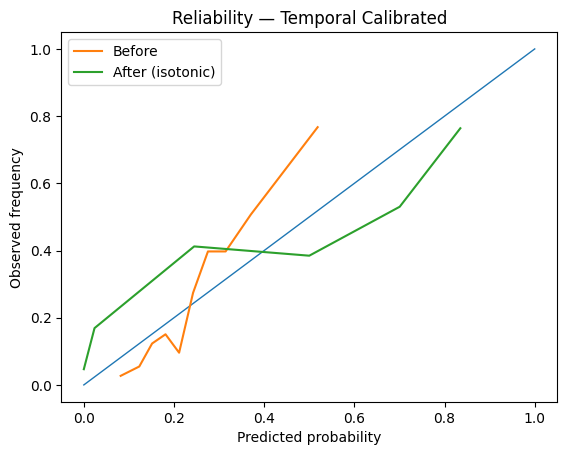

Saved: d:\reports\calibration_temporal_best.png


In [66]:
# ---- Temporal calibration chooser: Identity vs Isotonic vs Platt (logistic) ----
assert 'use_model' in globals() and 'feature_cols' in globals() and 'fa' in globals()
reports_dir = os.path.abspath(os.path.join(os.getcwd(), "../../reports")); os.makedirs(reports_dir, exist_ok=True)

cutoff = int(globals().get("TRAIN_CUTOFF_YEAR", 2003))
# Temporal splits inside TRAIN
fit_mask = fa['movie_year'] <= (cutoff - 2)              # model fit era
cal_mask = (fa['movie_year'] > (cutoff - 2)) & (fa['movie_year'] <= cutoff)  # calibration era
test_mask = fa['movie_year'] > cutoff

# Binary label defined on the FIT era only (no peeking)
th = fa.loc[fit_mask, 'resonance'].quantile(0.75)
y_all = (fa['resonance'] >= th).astype(int)

# Base model probs on CAL and TEST
p_cal = predict_proba_aligned(use_model, fa.loc[cal_mask].copy(), feature_cols, flip=bool(globals().get('FLIP', False)), positive_label=1)
y_cal = y_all.loc[cal_mask].values

p_te  = predict_proba_aligned(use_model, fa.loc[test_mask].copy(), feature_cols, flip=bool(globals().get('FLIP', False)), positive_label=1)
y_te  = y_all.loc[test_mask].values

# 1) Identity (no calibration)
def _id(x): return np.asarray(x)
brier_id = brier_score_loss(y_cal, _id(p_cal))

# 2) Isotonic on CAL
ISO_CAL = IsotonicRegression(out_of_bounds='clip').fit(p_cal, y_cal)
def _iso(x): return np.clip(ISO_CAL.predict(np.asarray(x)), 1e-6, 1-1e-6)
brier_iso = brier_score_loss(y_cal, _iso(p_cal))

# 3) Platt (logistic) on CAL
PLATT_CAL = LogisticRegression(max_iter=200).fit(p_cal.reshape(-1,1), y_cal)
def _platt(x): 
    x = np.asarray(x).reshape(-1,1)
    return np.clip(PLATT_CAL.predict_proba(x)[:,1], 1e-6, 1-1e-6)
brier_platt = brier_score_loss(y_cal, _platt(p_cal))

print(f"Calibration (temporal validation) Brier:")
print(f"  Identity : {brier_id:.4f}")
print(f"  Isotonic : {brier_iso:.4f}")
print(f"  Platt    : {brier_platt:.4f}")

# Choose best on CAL
best_name, APPLIER = min(
    [("identity", _id), ("isotonic", _iso), ("platt", _platt)],
    key=lambda kv: brier_score_loss(y_cal, kv[1](p_cal))
)
CAL_METHOD = best_name
print("Chosen calibration:", CAL_METHOD)

# Apply chosen calibration to TEST and plot reliability before/after
p_te_cal = APPLIER(p_te)
b_before = brier_score_loss(y_te, p_te)
b_after  = brier_score_loss(y_te, p_te_cal)
print(f"TEST Brier  before: {b_before:.4f} | after ({CAL_METHOD}): {b_after:.4f} | Δ: {b_after - b_before:+.4f}")

pt_b, pp_b = calibration_curve(y_te, p_te,     n_bins=10, strategy="quantile")
pt_a, pp_a = calibration_curve(y_te, p_te_cal, n_bins=10, strategy="quantile")

plt.figure()
plt.plot([0,1],[0,1], linewidth=1)
plt.plot(pp_b, pt_b, label="Before")
plt.plot(pp_a, pt_a, label=f"After ({CAL_METHOD})")
plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
plt.title("Reliability — Temporal Calibrated")
plt.legend()
cal_ba_path = os.path.join(reports_dir, "calibration_temporal_best.png")
plt.savefig(cal_ba_path, bbox_inches="tight"); plt.show()
print("Saved:", cal_ba_path)

# Serving-time helper that uses the chosen method
def apply_calibration_probs(probs: np.ndarray) -> np.ndarray:
    return APPLIER(np.asarray(probs))


Class prevalence: 0.279
ROC AUC: 0.806
PR AUC : 0.629
Brier  : 0.1623


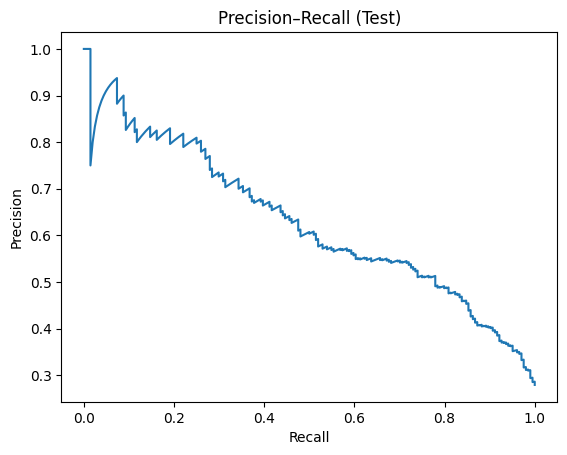

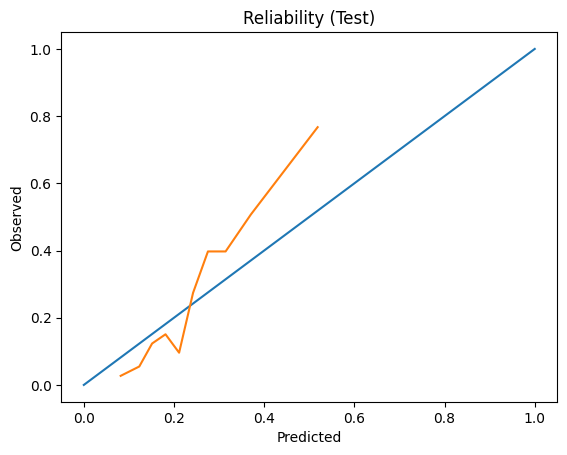

Saved: d:\Cast_and_Crew\reports\pr_curve.png and d:\Cast_and_Crew\reports\calibration_curve.png


In [67]:


reports_dir = os.path.abspath(os.path.join(os.getcwd(), "../Cast_and_Crew/reports"))
os.makedirs(reports_dir, exist_ok=True)

def _get_test_data_and_probs():
    if 'use_model' not in globals() or use_model is None:
        raise RuntimeError("`use_model` is not defined. Train/select the model earlier in the notebook.")
    if 'feature_cols' not in globals():
        raise RuntimeError("`feature_cols` not found. Build engineered features and set `feature_cols` first.")
    flip_flag = bool(globals().get("FLIP", False))

    if 'X_te' in globals() and 'y_te' in globals():
        frame = pd.DataFrame(X_te, columns=feature_cols) if not isinstance(X_te, pd.DataFrame) else X_te.copy()
        p = predict_proba_aligned(use_model, frame.copy(), feature_cols, flip=flip_flag, positive_label=1)
        return y_te, p

    if 'fa' not in globals():
        raise RuntimeError("`fa` not found. Execute earlier cells to build it.")
    cutoff = globals().get("TRAIN_CUTOFF_YEAR", 2003)
    is_train = fa['movie_year'] <= cutoff
    is_test  = fa['movie_year'] >  cutoff
    if 'resonance' not in fa.columns:
        raise RuntimeError("`resonance` not found in `fa`.")

    thresh = fa.loc[is_train, 'resonance'].quantile(0.75)
    y_all  = (fa['resonance'] >= thresh).astype(int)
    y_test = y_all.loc[is_test].values

    test_frame = fa.loc[is_test].copy()
    p = predict_proba_aligned(use_model, test_frame, feature_cols, flip=flip_flag, positive_label=1)
    return y_test, p

y_test, probs = _get_test_data_and_probs()
prevalence = float(np.mean(y_test))
roc = roc_auc_score(y_test, probs)
pr_auc = average_precision_score(y_test, probs)
brier = brier_score_loss(y_test, probs)

print(f"Class prevalence: {prevalence:.3f}")
print(f"ROC AUC: {roc:.3f}")
print(f"PR AUC : {pr_auc:.3f}")
print(f"Brier  : {brier:.4f}")

prec, rec, _ = precision_recall_curve(y_test, probs)
plt.figure(); plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall (Test)")
plt.savefig(os.path.join(reports_dir, "pr_curve.png"), bbox_inches="tight"); plt.show()

prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10, strategy="quantile")
plt.figure(); plt.plot([0,1],[0,1]); plt.plot(prob_pred, prob_true); plt.xlabel("Predicted"); plt.ylabel("Observed"); plt.title("Reliability (Test)")
plt.savefig(os.path.join(reports_dir, "calibration_curve.png"), bbox_inches="tight"); plt.show()

print("Saved:", os.path.join(reports_dir, "pr_curve.png"), "and", os.path.join(reports_dir, "calibration_curve.png"))


In [68]:
def expected_calibration_error(y_true, y_prob, n_bins: int = 15):
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    idx = np.digitize(y_prob, bins) - 1
    ece = 0.0
    for b in range(n_bins):
        mask = idx == b
        if not np.any(mask):
            continue
        conf = y_prob[mask].mean()
        acc  = y_true[mask].mean()
        ece += (mask.mean()) * abs(acc - conf)
    return float(ece)

def eval_extra_metrics(y_true, y_prob):
    pr_auc = average_precision_score(y_true, y_prob) if len(set(y_true))>1 else float('nan')
    ece    = expected_calibration_error(y_true, y_prob, n_bins=15)
    brier  = brier_score_loss(y_true, y_prob)
    return {"pr_auc": pr_auc, "ece": ece, "brier": brier}

# Example usage (uncomment if you have y_te and p_te from holdout):
extra = eval_extra_metrics(y_te, p_te)
print({k: f"{v:.4f}" for k,v in extra.items()})


{'pr_auc': '0.6292', 'ece': '0.0872', 'brier': '0.1623'}


## Per-year test performance (fixed model)

,year,auc,pr_auc,prevalence
0,2004,0.770000,0.552969,0.212598
1,2005,0.763378,0.502145,0.259843
2,2006,0.906658,0.733151,0.248000
3,2007,0.770948,0.516918,0.260163
4,2008,0.817812,0.777106,0.333333
5,2009,0.815294,0.717087,0.311927


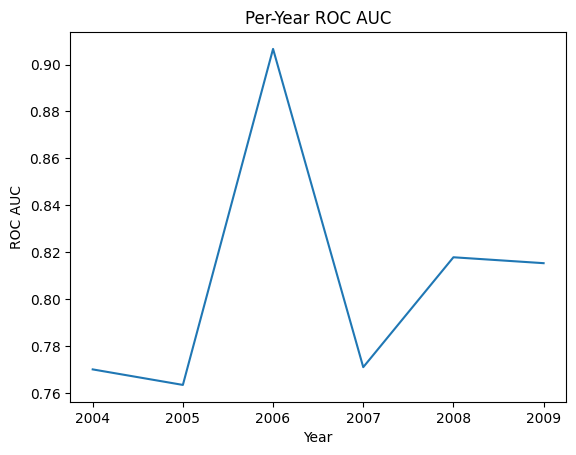

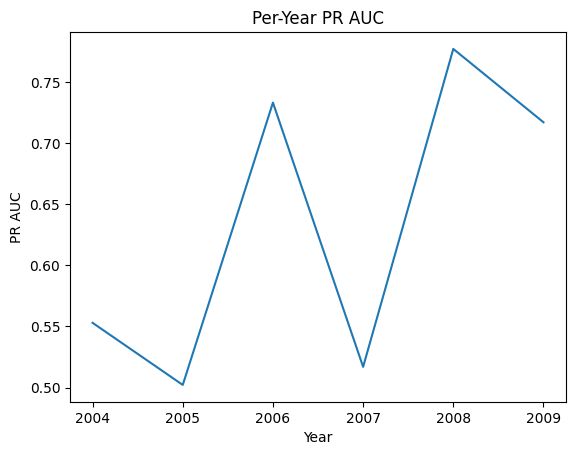

Saved: d:\Cast_and_Crew\reports\per_year_auc.png and d:\Cast_and_Crew\reports\per_year_pr_auc.png


In [69]:
cutoff = globals().get("TRAIN_CUTOFF_YEAR", 2003)
years = sorted([y for y in fa['movie_year'].unique() if y > cutoff])

rows = []
for yr in years:
    mask = fa['movie_year'] == yr
    if not mask.any(): continue
    thresh = fa.loc[fa['movie_year'] <= cutoff, 'resonance'].quantile(0.75)
    y = (fa.loc[mask, 'resonance'] >= thresh).astype(int).values
    slice_frame = fa.loc[mask].copy()
    flip_flag = bool(globals().get("FLIP", False))
    p = predict_proba_aligned(use_model, slice_frame, feature_cols, flip=flip_flag, positive_label=1)
    auc = roc_auc_score(y, p) if len(np.unique(y)) > 1 else np.nan
    ap  = average_precision_score(y, p) if len(np.unique(y)) > 1 else np.nan
    rows.append((yr, auc, ap, float(np.mean(y))))

per_year_df = pd.DataFrame(rows, columns=["year","auc","pr_auc","prevalence"])
display(per_year_df)

reports_dir = os.path.abspath(os.path.join(os.getcwd(), "../Cast_and_Crew/reports"))
os.makedirs(reports_dir, exist_ok=True)

plt.figure(); plt.plot(per_year_df["year"], per_year_df["auc"]); plt.xlabel("Year"); plt.ylabel("ROC AUC"); plt.title("Per-Year ROC AUC")
plt.savefig(os.path.join(reports_dir, "per_year_auc.png"), bbox_inches="tight"); plt.show()

plt.figure(); plt.plot(per_year_df["year"], per_year_df["pr_auc"]); plt.xlabel("Year"); plt.ylabel("PR AUC"); plt.title("Per-Year PR AUC")
plt.savefig(os.path.join(reports_dir, "per_year_pr_auc.png"), bbox_inches="tight"); plt.show()

print("Saved:", os.path.join(reports_dir, "per_year_auc.png"), "and", os.path.join(reports_dir, "per_year_pr_auc.png"))


# Temporal Cycle Head (Residual, Fourier)

This section adds a **residual cycle head**: we fit **logit residuals** on the train window using **Fourier year terms**
and **per-genre offsets**, then project that correction forward to adjust long-horizon predictions, leakage-safe.

Artifacts saved to `../Cast_and_Crew/reports/`:
- `cycle_head_residual_fit.png` (residuals vs. Fourier fit on train)
- `horizon_uplift_pr_auc.png` and `horizon_uplift_brier.png` (base vs. cycle head by year)


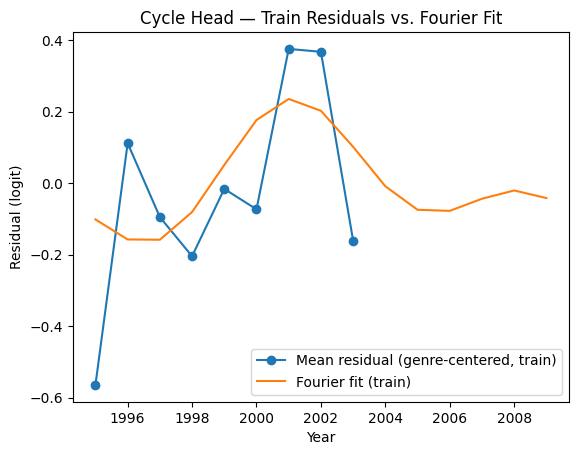

Saved: d:\Cast_and_Crew\reports\cycle_head_residual_fit.png


In [70]:
# Requirements: use_model, feature_cols, fa, TRAIN_CUTOFF_YEAR, predict_proba_aligned
if 'use_model' not in globals() or use_model is None:
    raise RuntimeError("`use_model` is not defined. Train/select the model earlier.")
if 'feature_cols' not in globals():
    raise RuntimeError("`feature_cols` not found. Build engineered features and set `feature_cols` first.")
if 'fa' not in globals():
    raise RuntimeError("`fa` (film-actor long frame) not found.")
cutoff = globals().get("TRAIN_CUTOFF_YEAR", 2003)

reports_dir = os.path.abspath(os.path.join(os.getcwd(), "../Cast_and_Crew/reports"))
os.makedirs(reports_dir, exist_ok=True)

# 1) Score all rows with base model (aligned)
fa_scored = fa.copy()
fa_scored["p_hat"] = predict_proba_aligned(
    use_model, fa_scored, feature_cols, flip=bool(globals().get("FLIP", False)), positive_label=1
)

# 2) Build binary label from TRAIN-era top quartile; avoid logit infinities
train_mask = fa_scored["movie_year"] <= cutoff
thresh = fa_scored.loc[train_mask, "resonance"].quantile(0.75)
y_bin = (fa_scored["resonance"] >= thresh).astype(float)

eps = 1e-3
y_smooth = y_bin*(1 - 2*eps) + eps  # 0 -> eps, 1 -> 1-eps
logit = lambda p: np.log(p/(1-p))

fa_scored["r_logit"] = logit(y_smooth.clip(eps, 1-eps)) - logit(fa_scored["p_hat"].clip(eps, 1-eps))

# 3) Coarse group: dominant genre affinity (if available)
aff_cols = [c for c in fa.columns if c.startswith("genre_") and c.endswith("_aff")]
if len(aff_cols) > 0:
    fa_scored["genre_bucket"] = fa_scored[aff_cols].idxmax(axis=1).fillna("genre_unknown")
else:
    fa_scored["genre_bucket"] = "genre_none"

# 4) Fourier features for year
y0, y1 = int(fa_scored["movie_year"].min()), int(fa_scored["movie_year"].max())
span = (y1 - y0) + 1.0

def fourier_year(df, K=2):
    t = 2*np.pi*(df["movie_year"] - y0)/span
    out = {}
    for k in range(1, K+1):
        out[f"sin{k}"] = np.sin(k*t)
        out[f"cos{k}"] = np.cos(k*t)
    return pd.DataFrame(out, index=df.index)

K = 2  # small to avoid overfit
F = fourier_year(fa_scored, K=K)

# 5) Fit on TRAIN rows: r_logit ~ Fourier(year) + genre offsets
train_df = pd.concat([fa_scored.loc[train_mask, ["r_logit","genre_bucket","movie_year"]], F.loc[train_mask]], axis=1).dropna()

# Per-genre mean offsets
genre_offsets = train_df.groupby("genre_bucket")["r_logit"].mean()

# OLS on Fourier, centered by genre offset
X = train_df[[c for c in F.columns]]
y = (train_df["r_logit"] - train_df["genre_bucket"].map(genre_offsets)).values
beta = np.linalg.lstsq(X.values, y, rcond=None)[0]

# Save fitted "cycle head" in-memory
cycle_head = {
    "beta": beta,
    "fourier_cols": list(X.columns),
    "genre_offsets": genre_offsets.to_dict(),
    "y0": y0,
    "span": float(span),
    "K": int(K),
    "cutoff": int(cutoff),
}

# 6) Diagnostic: residual means by year vs. Fourier fit (genre-centered)
diag = train_df.copy()
diag["r_centered"] = diag["r_logit"] - diag["genre_bucket"].map(genre_offsets)
yr_means = diag.groupby("movie_year")["r_centered"].mean()

years_all = np.arange(y0, y1+1)
def fourier_for_year(y, K, y0, span):
    t = 2*np.pi*(y - y0)/span
    vals = []
    for k in range(1, K+1):
        vals += [np.sin(k*t), np.cos(k*t)]
    return np.array(vals)

pred_cycle = []
for yy in years_all:
    vec = fourier_for_year(yy, cycle_head["K"], cycle_head["y0"], cycle_head["span"])
    pred_cycle.append(float(vec @ cycle_head["beta"]))

plt.figure()
plt.plot(yr_means.index, yr_means.values, marker='o', label="Mean residual (genre-centered, train)")
plt.plot(years_all, pred_cycle, label="Fourier fit (train)")
plt.xlabel("Year"); plt.ylabel("Residual (logit)")
plt.title("Cycle Head — Train Residuals vs. Fourier Fit")
plt.legend()
fit_path = os.path.join(reports_dir, "cycle_head_residual_fit.png")
plt.savefig(fit_path, bbox_inches="tight"); plt.show()
print("Saved:", fit_path)


,year,pr_base,pr_cycle,brier_base,brier_cycle
0,2004,0.552969,0.548428,0.138982,0.162368
1,2005,0.502145,0.479424,0.165575,0.211257
2,2006,0.733151,0.682396,0.141364,0.199735
3,2007,0.516918,0.512063,0.166415,0.212582
4,2008,0.777106,0.762785,0.172756,0.256998
5,2009,0.717087,0.672704,0.173175,0.247990


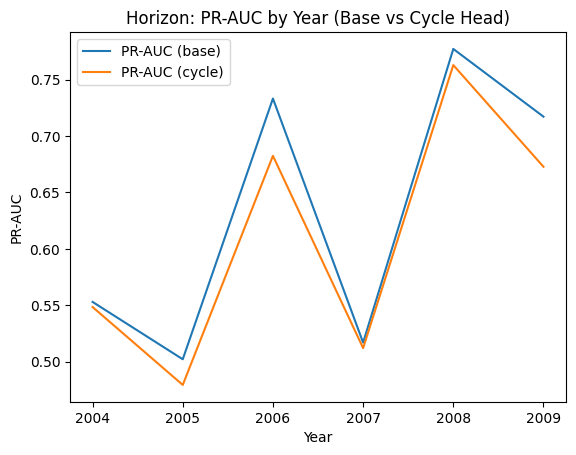

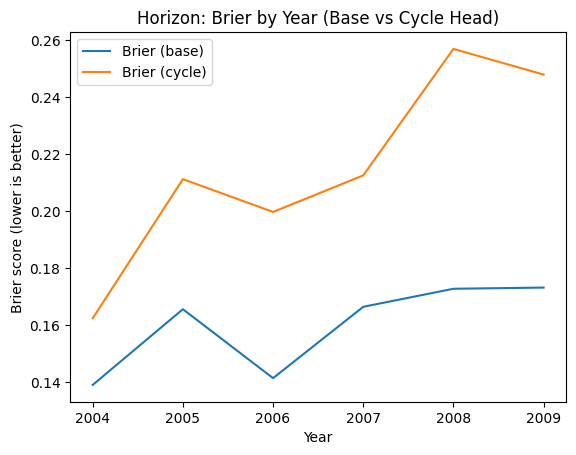

Saved: d:\Cast_and_Crew\reports\horizon_uplift_pr_auc.png and d:\Cast_and_Crew\reports\horizon_uplift_brier.png


In [71]:
# Functions to apply the cycle head to any candidate frame for a given year
def _cycle_adjustment_for_year(year: int) -> float:
    t = 2*np.pi*(year - cycle_head["y0"]) / cycle_head["span"]
    vals = []
    for k in range(1, cycle_head["K"]+1):
        vals += [np.sin(k*t), np.cos(k*t)]
    return float(np.array(vals) @ np.array(cycle_head["beta"]))

def cycle_adjustment(year: int, genre_bucket: str) -> float:
    base = _cycle_adjustment_for_year(year)
    g_off = cycle_head["genre_offsets"].get(genre_bucket, 0.0)
    return base + g_off

def apply_cycle_to_candidates(cand_df: pd.DataFrame, year: int, alpha: float = 0.7) -> pd.Series:
    """Adjusts p_high using cycle head in the logit domain; returns adjusted probability."""
    eps = 1e-6
    # Ensure genre_bucket exists
    aff_cols = [c for c in cand_df.columns if c.startswith("genre_") and c.endswith("_aff")]
    if len(aff_cols) > 0:
        for c in aff_cols:
            if c not in cand_df.columns: cand_df[c] = 0.0
        cand_df["genre_bucket"] = cand_df[aff_cols].idxmax(axis=1).fillna("genre_unknown")
    else:
        cand_df["genre_bucket"] = "genre_none"

    p = cand_df["p_high"].clip(eps, 1-eps)
    z = np.log(p/(1-p))  # logit
    adj = cand_df["genre_bucket"].apply(lambda g: cycle_adjustment(year, g))
    z_adj = z + alpha * adj
    p_adj = 1 / (1 + np.exp(-z_adj))
    return p_adj

# Horizon comparison: PR-AUC and Brier per test year (base vs cycle head)
alpha_cycle = 0.7  # tune via CV if desired
cutoff = cycle_head["cutoff"]

years = sorted([int(y) for y in fa["movie_year"].unique() if y > cutoff])
rows = []

for yr in years:
    mask = fa["movie_year"] == yr
    if not mask.any():
        continue

    # Binary labels using TRAIN-era threshold
    thresh = fa.loc[fa["movie_year"] <= cutoff, "resonance"].quantile(0.75)
    y = (fa.loc[mask, "resonance"] >= thresh).astype(int).values

    # Base predictions
    slice_frame = fa.loc[mask].copy()
    p_base = predict_proba_aligned(use_model, slice_frame, feature_cols, flip=bool(globals().get("FLIP", False)), positive_label=1)

    # Attach genre bucket, then cycle adjust
    aff_cols = [c for c in slice_frame.columns if c.startswith("genre_") and c.endswith("_aff")]
    if len(aff_cols) > 0:
        for c in aff_cols:
            if c not in slice_frame.columns: slice_frame[c] = 0.0
        slice_frame["genre_bucket"] = slice_frame[aff_cols].idxmax(axis=1).fillna("genre_unknown")
    else:
        slice_frame["genre_bucket"] = "genre_none"

    cand_tmp = slice_frame.copy()
    cand_tmp["p_high"] = p_base
    p_adj = apply_cycle_to_candidates(cand_tmp, yr, alpha=alpha_cycle).values

    # Metrics (guard for single-class slices)
    if len(np.unique(y)) < 2:
        pr_base = np.nan; pr_adj = np.nan
        brier_base = np.nan; brier_adj = np.nan
    else:
        pr_base = average_precision_score(y, p_base)
        pr_adj  = average_precision_score(y, p_adj)
        brier_base = brier_score_loss(y, p_base)
        brier_adj  = brier_score_loss(y, p_adj)

    rows.append((yr, pr_base, pr_adj, brier_base, brier_adj))

hdf = pd.DataFrame(rows, columns=["year","pr_base","pr_cycle","brier_base","brier_cycle"]).sort_values("year")
display(hdf)

# Save plots
plt.figure()
plt.plot(hdf["year"], hdf["pr_base"], label="PR-AUC (base)")
plt.plot(hdf["year"], hdf["pr_cycle"], label="PR-AUC (cycle)")
plt.xlabel("Year"); plt.ylabel("PR-AUC"); plt.title("Horizon: PR-AUC by Year (Base vs Cycle Head)"); plt.legend()
pr_uplift_path = os.path.join(reports_dir, "horizon_uplift_pr_auc.png")
plt.savefig(pr_uplift_path, bbox_inches="tight"); plt.show()

plt.figure()
plt.plot(hdf["year"], hdf["brier_base"], label="Brier (base)")
plt.plot(hdf["year"], hdf["brier_cycle"], label="Brier (cycle)")
plt.xlabel("Year"); plt.ylabel("Brier score (lower is better)"); plt.title("Horizon: Brier by Year (Base vs Cycle Head)"); plt.legend()
brier_uplift_path = os.path.join(reports_dir, "horizon_uplift_brier.png")
plt.savefig(brier_uplift_path, bbox_inches="tight"); plt.show()

print("Saved:", pr_uplift_path, "and", brier_uplift_path)


Calibration Brier on temporal CAL slice: {'identity': 0.1113, 'isotonic': 0.065, 'platt': 0.0976}
Chosen calibration: isotonic
TEST Brier  before: 0.1623 | after (isotonic): 0.1687 | Δ: +0.0064


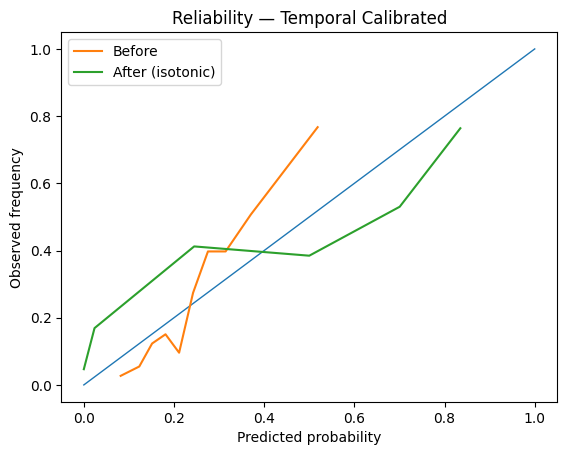

Saved: d:\Cast_and_Crew\reports\calibration_temporal_best.png


In [72]:
# ---- Temporal calibration chooser: pick Identity vs Isotonic vs Platt by Brier on a temporal validation slice ----
assert 'use_model' in globals() and 'feature_cols' in globals() and 'fa' in globals()
reports_dir = os.path.abspath(os.path.join(os.getcwd(), "../Cast_and_Crew/reports")); os.makedirs(reports_dir, exist_ok=True)

cutoff = int(globals().get("TRAIN_CUTOFF_YEAR", 2003))

# Temporal split inside TRAIN: fit-era and the latest 1–2 years for CAL
fit_mask = fa['movie_year'] <= (cutoff - 2)
cal_mask = (fa['movie_year'] > (cutoff - 2)) & (fa['movie_year'] <= cutoff)
test_mask = fa['movie_year'] > cutoff

# Label threshold defined ONLY on the fit-era (no peeking)
th = fa.loc[fit_mask, 'resonance'].quantile(0.75)
y_all = (fa['resonance'] >= th).astype(int)

# Base model probabilities on CAL and TEST
p_cal = predict_proba_aligned(use_model, fa.loc[cal_mask].copy(), feature_cols, flip=bool(globals().get('FLIP', False)), positive_label=1)
y_cal = y_all.loc[cal_mask].values

p_te  = predict_proba_aligned(use_model, fa.loc[test_mask].copy(), feature_cols, flip=bool(globals().get('FLIP', False)), positive_label=1)
y_te  = y_all.loc[test_mask].values

# Make sure these are numpy arrays (avoids Series/shape surprises)
p_cal = np.asarray(p_cal, dtype=float)
p_te  = np.asarray(p_te , dtype=float)

# 1) Identity (no calibration)
def _id(x):
    x = np.asarray(x, dtype=float)
    return x

# 2) Isotonic on CAL
ISO_CAL = IsotonicRegression(out_of_bounds='clip').fit(p_cal, y_cal)
def _iso(x):
    x = np.asarray(x, dtype=float)
    return np.clip(ISO_CAL.predict(x), 1e-6, 1-1e-6)

# 3) Platt (logistic) on CAL
PLATT_CAL = LogisticRegression(max_iter=300)
PLATT_CAL.fit(p_cal.reshape(-1,1), y_cal)
def _platt(x):
    x = np.asarray(x, dtype=float).reshape(-1,1)
    return np.clip(PLATT_CAL.predict_proba(x)[:,1], 1e-6, 1-1e-6)

# Score calibrators on the temporal CAL slice
methods = {"identity": _id, "isotonic": _iso, "platt": _platt}
cal_brier = {name: brier_score_loss(y_cal, fn(p_cal)) for name, fn in methods.items()}
print("Calibration Brier on temporal CAL slice:", {k: round(v,4) for k,v in cal_brier.items()})

# Pick the best & expose an applier
CAL_METHOD = min(cal_brier, key=cal_brier.get)
APPLIER = methods[CAL_METHOD]
print("Chosen calibration:", CAL_METHOD)

# Apply to TEST and show before/after reliability + Brier
p_te_cal = APPLIER(p_te)
b_before = brier_score_loss(y_te, p_te)
b_after  = brier_score_loss(y_te, p_te_cal)
print(f"TEST Brier  before: {b_before:.4f} | after ({CAL_METHOD}): {b_after:.4f} | Δ: {b_after - b_before:+.4f}")

pt_b, pp_b = calibration_curve(y_te, p_te,     n_bins=10, strategy="quantile")
pt_a, pp_a = calibration_curve(y_te, p_te_cal, n_bins=10, strategy="quantile")

plt.figure()
plt.plot([0,1],[0,1], linewidth=1)
plt.plot(pp_b, pt_b, label="Before")
plt.plot(pp_a, pt_a, label=f"After ({CAL_METHOD})")
plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
plt.title("Reliability — Temporal Calibrated")
plt.legend()
cal_ba_path = os.path.join(reports_dir, "calibration_temporal_best.png")
plt.savefig(cal_ba_path, bbox_inches="tight"); plt.show()
print("Saved:", cal_ba_path)

# Serving-time helper (used by recommend_cast if calibrate=True)
def apply_calibration_probs(probs):
    return APPLIER(np.asarray(probs, dtype=float))


,feature,mean,std
12,budget,0.262010,0.022510
6,bill_order,0.016354,0.004172
8,genre_drama_aff,0.002934,0.003764
0,atr3,0.001654,0.004633
2,bfd,0.001540,0.002980
3,release_density,0.000138,0.000777
1,dtr3,0.000000,0.000000
4,year_sin,0.000000,0.000000
11,genre_romance_aff,-0.000425,0.001862
5,year_cos,-0.001148,0.001805


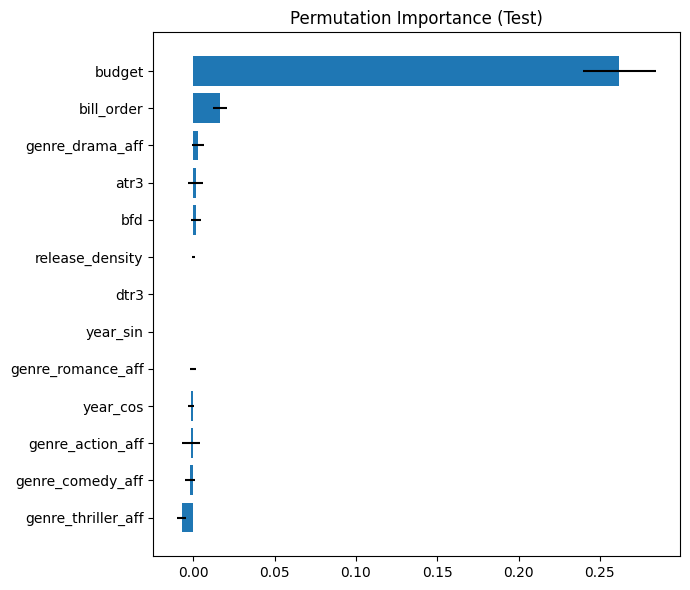

In [ ]:
# Product — Permutation Importance (Test)
reports_dir = os.path.abspath(os.path.join(os.getcwd(), "../Cast_and_Crew/reports")); os.makedirs(reports_dir, exist_ok=True)

# Build test split using global cutoff + quartile label
cutoff = globals().get("TRAIN_CUTOFF_YEAR", 2003)
is_tr = fa.movie_year<=cutoff; is_te = fa.movie_year>cutoff
th = fa.loc[is_tr,'resonance'].quantile(0.75)
y_all = (fa['resonance']>=th).astype(int)
X_te = fa.loc[is_te, feature_cols].copy(); y_te = y_all.loc[is_te].values
for c in feature_cols:
    if c not in X_te.columns: X_te[c]=0.0
X_te = X_te[feature_cols].fillna(0.0)

res = permutation_importance(use_model, X_te, y_te, scoring='roc_auc', n_repeats=10, random_state=42, n_jobs=-1)
imp = pd.DataFrame({'feature':feature_cols,'mean':res.importances_mean,'std':res.importances_std}).sort_values('mean',ascending=False)
display(imp.head(20))
top = imp.head(15)

plt.figure(figsize=(7,6))
plt.barh(
    top["feature"].iloc[::-1],
    top["mean"].iloc[::-1],
    xerr=top["std"].iloc[::-1]
)
plt.title("Permutation Importance (Test)")
plt.tight_layout()
plt.savefig(os.path.join(reports_dir, "permutation_importance_test.png"), bbox_inches="tight")
#plt.show()


In [74]:
# Product — Ablations (Retrain clones without groups)
genre_affs = [c for c in feature_cols if c.startswith("genre_") and c.endswith("_aff")]
groups = {
    "ALL (baseline)": [],
    "No ATR/DTR": ["atr3","dtr3"],
    "No BFD": ["bfd"],
    "No ReleaseDensity": ["release_density"],
    "No Time": ["year_sin","year_cos"],
    "No Budget": ["budget"] if "budget" in feature_cols else [],
    "No BillOrder": ["bill_order"],
    "No GenreAff": genre_affs,
}

X_tr = fa.loc[fa.movie_year<=cutoff, feature_cols].copy().fillna(0.0)
y_tr = (fa.loc[fa.movie_year<=cutoff, 'resonance']>=th).astype(int).values
X_te = fa.loc[fa.movie_year>cutoff, feature_cols].copy().fillna(0.0)
y_te = (fa.loc[fa.movie_year>cutoff, 'resonance']>=th).astype(int).values

def _fit_eval(remove):
    keep=[f for f in feature_cols if f not in remove]
    m=clone(use_model).fit(X_tr[keep], y_tr)
    pos=1; 
    if hasattr(m,"classes_"): cs=list(m.classes_); pos=cs.index(1) if 1 in cs else (cs.index(max(cs)) if len(cs)==2 else 1)
    p=m.predict_proba(X_te[keep])[:,pos]
    auc=roc_auc_score(y_te,p) if len(np.unique(y_te))>1 else np.nan
    pr =average_precision_score(y_te,p) if len(np.unique(y_te))>1 else np.nan
    br =brier_score_loss(y_te,p)
    return auc,pr,br

base_auc,base_pr,base_br=_fit_eval(groups["ALL (baseline)"])
rows=[]
for name,rm in groups.items():
    auc,pr,br=_fit_eval(rm); rows.append((name,auc,pr,br, auc-base_auc, pr-base_pr, br-base_br))
abl=pd.DataFrame(rows,columns=["setting","auc","pr_auc","brier","Δauc","Δpr_auc","Δbrier"]).sort_values("setting")
# display(abl); abl.to_csv(os.path.join(reports_dir,"ablation_table.csv"), index=False)


## Reason Code Generation for Human-in-the-Loop operations

In [75]:
# --- Reference vector for reason codes (train-era mean per feature) ---
try:
    REF_VEC  # keep existing if already set
except NameError:
    if 'X_tr' in globals():
        REF_VEC = X_tr[feature_cols].mean().to_dict()
        print("[rc] REF_VEC from X_tr means")
    else:
        # Fallback: neutral zeros
        REF_VEC = {c: 0.0 for c in feature_cols}
        print("[rc] REF_VEC fallback (zeros)")

[rc] REF_VEC from X_tr means


In [76]:
# --- Per-row reason codes (feature knockouts vs. REF_VEC) ---
def _proba_row(model, row_s: pd.Series) -> float:
    X1 = pd.DataFrame([row_s])
    # enforce contract/order
    for col in feature_cols:
        if col not in X1.columns:
            X1[col] = 0.0
    X1 = X1[feature_cols].fillna(0).astype(float)
    return model.predict_proba(X1)[:, list(model.classes_).index(1)][0]

def reason_codes_for_rows(model, X_rows: pd.DataFrame, k: int = 3, ref_vec: dict | None = None) -> pd.DataFrame:
    """
    For each row in X_rows (indexed by actor_name), compute top-k features that,
    when replaced by a reference value, reduce the probability the most.
    """
    if ref_vec is None:
        ref_vec = globals().get('REF_VEC', {c: 0.0 for c in feature_cols})

    out = []
    for idx, row in X_rows.iterrows():
        base = _proba_row(model, row)
        deltas = []
        for f in X_rows.columns:
            prt = row.copy()
            prt[f] = ref_vec.get(f, 0.0)
            p2 = _proba_row(model, prt)
            deltas.append((f, base - p2, row[f], ref_vec.get(f, 0.0)))
        deltas.sort(key=lambda x: x[1], reverse=True)
        top = deltas[:k]
        rec = {"actor_name": idx}
        for i, (fname, drop, val, refv) in enumerate(top, start=1):
            rec[f"rc_{i}_feature"] = fname
            rec[f"rc_{i}_delta"]   = float(drop)
            rec[f"rc_{i}_value"]   = float(val) if np.isscalar(val) else None
        out.append(rec)
    return pd.DataFrame(out)


In [77]:
# --- Reason codes: convert wide -> long, and normalizer that accepts both ---
def reason_codes_wide_to_long(rc_wide: pd.DataFrame) -> pd.DataFrame:
    """
    Convert columns like rc_1_feature / rc_1_delta into rows with:
    row | feature | delta
    """
    if rc_wide is None or rc_wide.empty:
        return pd.DataFrame(columns=["row","feature","delta"])
    # pick an actor identifier column
    actor_col = "actor_name" if "actor_name" in rc_wide.columns else ("row" if "row" in rc_wide.columns else None)
    if actor_col is None:
        # fall back to first column
        actor_col = rc_wide.columns[0]

    # detect available indices (1..K)
    idxs = []
    for c in rc_wide.columns:
        m = re.match(r"rc_(\d+)_delta$", c)
        if m:
            idxs.append(int(m.group(1)))
    idxs = sorted(set(idxs))
    if not idxs:
        return pd.DataFrame(columns=["row","feature","delta"])

    rows = []
    for _, r in rc_wide.iterrows():
        who = r.get(actor_col, None)
        for i in idxs:
            fcol = f"rc_{i}_feature"; dcol = f"rc_{i}_delta"
            if fcol in rc_wide.columns and dcol in rc_wide.columns:
                f = r.get(fcol, None)
                d = r.get(dcol, None)
                if pd.notna(f) and pd.notna(d):
                    rows.append({"row": who, "feature": str(f), "delta": float(d)})
    return pd.DataFrame(rows)

def ensure_rc_long(df: pd.DataFrame) -> pd.DataFrame:
    """
    If df already has columns ['row','feature','delta'], return it.
    Otherwise try to convert from wide format.
    """
    if df is None or df.empty:
        return pd.DataFrame(columns=["row","feature","delta"])
    cols = set(df.columns)
    need = {"row","feature","delta"}
    if need.issubset(cols):
        return df[["row","feature","delta"]].copy()
    # else: try wide -> long
    return


## Cycle Head - Alpha Tuning

,alpha,mean_pr_auc,mean_brier
0,0.3,0.520187,0.160991
1,0.4,0.520140,0.166921
2,0.5,0.520084,0.173454
3,0.6,0.514096,0.180186
4,0.7,0.513926,0.186812
5,0.8,0.513652,0.193117
6,0.9,0.516231,0.198961
7,1.0,0.515853,0.204264
8,1.1,0.513656,0.208995
9,1.2,0.510014,0.213157


Chosen ALPHA_CYCLE = 0.300


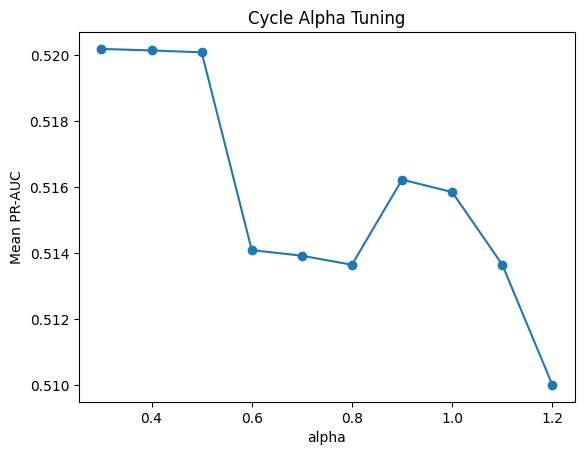

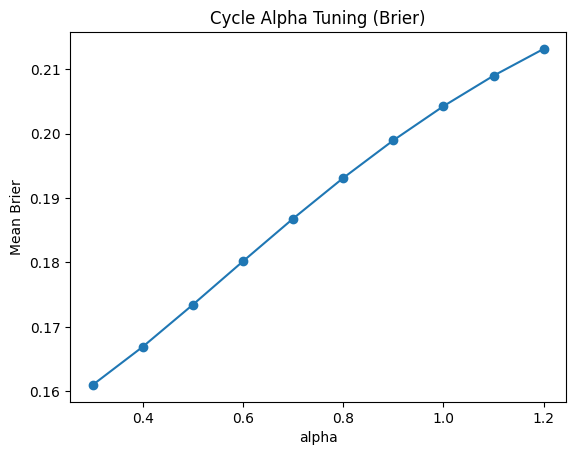

In [78]:
# Alpha Tuning (uses first 1–2 post-cutoff years)
reports_dir = os.path.abspath(os.path.join(os.getcwd(), "../Cast_and_Crew/reports")); os.makedirs(reports_dir, exist_ok=True)
if 'cycle_head' not in globals(): raise RuntimeError("Fit the 'Temporal Cycle Head' section first.")
years = sorted([int(y) for y in fa.movie_year.unique() if y>cycle_head["cutoff"]])
tune_years = years[:min(2,len(years))]
def apply_cycle_to_candidates(cdf, year, alpha=0.7):
    eps=1e-6
    aff=[c for c in cdf.columns if c.startswith("genre_") and c.endswith("_aff")]
    if aff: cdf["genre_bucket"]=cdf[aff].idxmax(axis=1).fillna("genre_unknown")
    else:   cdf["genre_bucket"]="genre_none"
    p=cdf["p_high"].clip(eps,1-eps); z=np.log(p/(1-p))
    def _adj(y, g):
        t=2*np.pi*(y-cycle_head["y0"])/cycle_head["span"]
        vals=np.array([u for k in range(1,cycle_head["K"]+1) for u in (np.sin(k*t), np.cos(k*t))])
        base=float(vals @ np.array(cycle_head["beta"])); goff=cycle_head["genre_offsets"].get(g,0.0)
        return base+goff
    adj=cdf["genre_bucket"].apply(lambda g: _adj(year,g))
    z_adj=z+alpha*adj; return 1/(1+np.exp(-z_adj))

alphas=np.linspace(0.3,1.2,10); rows=[]
for a in alphas:
    prs=[]; brs=[]
    for yr in tune_years:
        m=fa.movie_year==yr
        if not m.any(): continue
        thr = fa.loc[fa.movie_year<=cycle_head["cutoff"],'resonance'].quantile(0.75)
        y = (fa.loc[m,'resonance']>=thr).astype(int).values
        sf = fa.loc[m].copy()
        p_base = predict_proba_aligned(use_model, sf, feature_cols, flip=bool(globals().get("FLIP",False)), positive_label=1)
        sf["p_high"]=p_base
        p_adj = apply_cycle_to_candidates(sf, yr, alpha=a).values
        if len(np.unique(y))<2: continue
        prs.append(average_precision_score(y,p_adj)); brs.append(brier_score_loss(y,p_adj))
    rows.append((a, float(np.nanmean(prs)) if prs else np.nan, float(np.nanmean(brs)) if brs else np.nan))
alpha_df=pd.DataFrame(rows, columns=["alpha","mean_pr_auc","mean_brier"]).dropna()
display(alpha_df.sort_values("alpha"))
ALPHA_CYCLE = float(alpha_df.loc[alpha_df["mean_pr_auc"].idxmax(),"alpha"]) if not alpha_df.empty else 0.7
print(f"Chosen ALPHA_CYCLE = {ALPHA_CYCLE:.3f}")
plt.figure(); plt.plot(alpha_df.alpha, alpha_df.mean_pr_auc, marker='o'); plt.xlabel("alpha"); plt.ylabel("Mean PR-AUC"); plt.title("Cycle Alpha Tuning")
plt.savefig(os.path.join(reports_dir,"cycle_alpha_tuning_pr_auc.png"), bbox_inches="tight"); plt.show()
plt.figure(); plt.plot(alpha_df.alpha, alpha_df.mean_brier, marker='o'); plt.xlabel("alpha"); plt.ylabel("Mean Brier"); plt.title("Cycle Alpha Tuning (Brier)")
plt.savefig(os.path.join(reports_dir,"cycle_alpha_tuning_brier.png"), bbox_inches="tight"); plt.show()


In [79]:
# --- Product guards: schema contract, temporal split, budget bins ---
def enforce_feature_contract(df: pd.DataFrame, feature_cols):
    """Ensure all training features exist and are ordered."""
    for c in feature_cols:
        if c not in df.columns:
            df[c] = 0.0
    return df.loc[:, list(feature_cols)].astype(float)

def check_temporal_split(fa: pd.DataFrame, cutoff: int):
    assert (fa.loc[fa.movie_year <= cutoff].shape[0] > 0) and (fa.loc[fa.movie_year > cutoff].shape[0] > 0), \
        "Temporal split empty on one side."
    # Train label threshold computed only on train slice, not test
    th_train = fa.loc[fa.movie_year <= cutoff, "resonance"].quantile(0.75)
    th_all   = fa["resonance"].quantile(0.75)
    # just a sanity echo
    print(f"[check] train-only threshold={th_train:.4f} (all-period {th_all:.4f} shown for context)")

def check_budget_bins():
    if 'budget_to_decile_using_train_bins' not in globals():
        print("[warn] train-era budget bins function not found; skip bin check.")
        return
    # monotonic edge check via a simple probe
    try:
        probes = [1e5, 5e5, 1e6, 5e6, 2e7, 1e8]
        decs = [budget_to_decile_using_train_bins(x) for x in probes]
        assert all(decs[i] <= decs[i+1] for i in range(len(decs)-1)), "Budget deciles not monotonic on probes."
        print(f"[check] budget deciles monotonic on probes → {list(zip(probes, decs))}")
    except Exception as e:
        print("[warn] budget bin check could not run:", e)


In [80]:
# --- Apply actor↔director synergy to an actor slate ---
def apply_synergy_to_actor_slate(slate: pd.DataFrame, director_name: str, weight: float = 0.25) -> pd.DataFrame:
    """
    Blend the actor's base logit with the pair's train-era success logit for (actor, director),
    using a convex weight in logit space. Requires PAIR_SYNERGY with columns:
    ['director_name', 'actor_name', 'phat'] where phat is success rate in train era.
    """
    if not director_name or 'PAIR_SYNERGY' not in globals() or PAIR_SYNERGY is None:
        return slate

    ps = PAIR_SYNERGY[PAIR_SYNERGY['director_name'] == director_name]
    if ps.empty:
        return slate

    m = ps.set_index('actor_name')['phat'].astype(float).to_dict()
    out = slate.copy()
    eps = 1e-6

    # base logits
    p = out['p_high'].clip(eps, 1-eps).to_numpy()
    z = np.log(p/(1-p))

    # target logits from pair synergy
    t = out['actor_name'].map(m)
    mask = t.notna().to_numpy()
    if mask.any():
        tm = t[mask].astype(float).to_numpy()
        z_t = np.log(np.clip(tm, eps, 1-eps)/np.clip(1-tm, eps, 1-eps))
        z[mask] = (1.0 - weight)*z[mask] + weight*z_t
        out['p_high'] = 1/(1+np.exp(-z))

    return out


## Slate definition


In [81]:
# --- Generate & save a slate (CSV artifacts) ---
# Fallback: if unsung_alternates wasn't run yet, create a tiny NN on actor features
if 'unsung_alternates' not in globals():
    stable_feats = ['atr3','dtr3','bill_order'] + [c for c in fa.columns if c.endswith('_aff')]
    actor_feat = fa.groupby('actor_name')[stable_feats].mean().replace([np.inf,-np.inf], np.nan).dropna()
    _nn = NearestNeighbors(n_neighbors=min(6, len(actor_feat)), metric='cosine').fit(actor_feat.values)
    def unsung_alternates(actor, k=3):
        if actor not in actor_feat.index: return []
        idx = actor_feat.index.get_loc(actor)
        dist, ind = _nn.kneighbors(actor_feat.iloc[[idx]].values, n_neighbors=min(k+1, len(actor_feat)))
        return [actor_feat.index[i] for i in ind[0] if actor_feat.index[i] != actor][:k]

def save_slate(year:int, budget:float, genres:list, bill_order:int=1, top_n:int=15,
               calibrate:bool=True, use_cycle:bool=True, alpha=None, out_dir=None,
               chosen_director:str=None, synergy_weight:float=0.25):
    """
    Runs recommend_cast, attaches alternates + reason codes, writes CSVs + a small JSON manifest.
    """
    os.makedirs(out_dir, exist_ok=True)
    # 1) Top slate
    slate = recommend_cast(year, budget, genres, bill_order, top_n=top_n,
                           calibrate=calibrate, use_cycle=use_cycle, alpha=alpha).copy()

    # --- optional synergy bump (if a director was chosen) ---
    if chosen_director:
        try:
            slate = apply_synergy_to_actor_slate(slate, chosen_director, weight=synergy_weight)
            slate = slate.sort_values('p_high', ascending=False).reset_index(drop=True)
            print(f"[synergy] applied with director='{chosen_director}', weight={synergy_weight}")
        except Exception as e:
            print("[synergy] skipped due to error:", e)
    # 2) Alternates (NN lookalikes)
    alt_rows = []
    for a in slate["actor_name"]:
        alts = unsung_alternates(a, k=3)
        for b in alts:
            alt_rows.append({"actor_name": a, "alternate": b})
    alt_df = pd.DataFrame(alt_rows)

    # 3) Reason codes (use your util if present)
    rc_df = None
    if 'reason_codes_for_rows' in globals():
        # Build a feature matrix for the same rows (aligned to training schema)
        # We need candidate features; use fa rows for these actors in the target year if present, else actor means
        # Simple approach: re-build candidate matrix and pick matching actors
        cand_all = build_candidate_matrix(fa_long=fa, as_of_year=year, film_budget=budget,
                                          bill_order=bill_order, feature_cols=feature_cols,
                                          stable_feats=stable_feats)
        cand_all = cand_all.set_index("actor_name")
        X_rows = enforce_feature_contract(cand_all.loc[slate["actor_name"], feature_cols], feature_cols)
        rc_df = reason_codes_for_rows(use_model, X_rows, k=3)
    else:
        print("[note] reason_codes_for_rows not found; skipping reason codes.")

    # 4) Write artifacts
    stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    base = f"slate_{year}_{int(budget):d}_bo{bill_order}_{stamp}"
    slate_path = os.path.join(out_dir, base + ".csv")
    slate.to_csv(slate_path, index=False)

    alt_path = os.path.join(out_dir, base + "_alternates.csv")
    alt_df.to_csv(alt_path, index=False)

    rc_path = None
    if rc_df is not None:
        rc_path = os.path.join(out_dir, base + "_reason_codes.csv")
        rc_df.to_csv(rc_path, index=False)

    manifest = {
        "year": year, "budget": budget, "bill_order": bill_order, "genres": genres,
        "calibrated": bool(calibrate),
        "cycle_used": bool(use_cycle and ('cycle_head' in globals())),
        "alpha_cycle": float(alpha) if alpha is not None else float(globals().get("ALPHA_CYCLE", 0.7)) if ('cycle_head' in globals()) else None,
        "calibration_method": globals().get("CAL_METHOD", "(none)"),
        "paths": {"slate": slate_path, "alternates": alt_path, "reason_codes": rc_path}
    }
    manifest_path = os.path.join(out_dir, base + "_manifest.json")
    with open(manifest_path, "w", encoding="utf-8") as f:
        json.dump(manifest, f, indent=2)

    print("Saved:")
    print(" -", slate_path)
    print(" -", alt_path)
    if rc_path: print(" -", rc_path)
    print(" -", manifest_path)
    return slate, alt_df, rc_df, manifest


In [82]:
# --- Budget sweep experiment (year fixed) ---
def jaccard_topk(a, b, k=10):
    A, B = set(a.head(k)), set(b.head(k))
    return len(A & B) / max(1, len(A | B))

def budget_sweep(year:int, genres:list, bill_order:int=1, budgets=(5e6, 2e7, 5e7, 1e8), top_n=15, use_cycle=True):
    rows = []
    slates = {}
    for B in budgets:
        slate = recommend_cast(year, B, genres, bill_order=bill_order, top_n=top_n,
                               calibrate=True, use_cycle=use_cycle)
        slate = slate.assign(year=year, budget=B, genres=", ".join(genres)).reset_index(drop=True)
        slates[B] = slate
        rows.append({
            "budget": B,
            "p_high_min": slate["p_high"].min(),
            "p_high_median": slate["p_high"].median(),
            "p_high_max": slate["p_high"].max(),
            "p_high_std": slate["p_high"].std(),
            "top1": slate.loc[0, "actor_name"],
            "top3": ", ".join(slate["actor_name"].head(3)),
        })
    # pairwise Jaccard of top-10 between adjacent budgets
    overlaps = []
    for b0, b1 in pairwise(budgets):
        overlaps.append({
            "from_budget": b0,
            "to_budget": b1,
            "jaccard_top10": jaccard_topk(slates[b0]["actor_name"], slates[b1]["actor_name"], k=10)
        })
    return pd.DataFrame(rows), pd.DataFrame(overlaps), slates

# Example sweep: same year, raise the cap
year = 2006
budgets = (10e6, 20e6, 50e6, 100e6, 150e6)
summary, overlap, slates = budget_sweep(year, genres=["Action","Thriller"], budgets=budgets, top_n=15, use_cycle=True)
#display(summary)
#display(overlap)
# Inspect deltas in names between two points:
slates[20e6][["actor_name","p_high"]].head(10), slates[100e6][["actor_name","p_high"]].head(10)


(  actor_name    p_high
 0  Actor_121  0.318463
 1  Actor_067  0.316265
 2  Actor_227  0.309796
 3  Actor_095  0.297135
 4  Actor_066  0.295348
 5  Actor_089  0.285901
 6  Actor_060  0.280786
 7  Actor_058  0.279270
 8  Actor_171  0.278516
 9  Actor_117  0.271964,
   actor_name    p_high
 0  Actor_227  0.522179
 1  Actor_009  0.500796
 2  Actor_006  0.499654
 3  Actor_096  0.496801
 4  Actor_205  0.496723
 5  Actor_121  0.496130
 6  Actor_116  0.490174
 7  Actor_067  0.488674
 8  Actor_095  0.487361
 9  Actor_070  0.486490)

In [83]:
# --- POLISH 2: Reason codes side-by-side for budget sensitivity ---
reports_dir = os.path.abspath(os.path.join(os.getcwd(), "../Cast_and_Crew/reports"))
os.makedirs(reports_dir, exist_ok=True)

def pick_overlap_and_exclusive(slates: dict, low_budget: float, high_budget: float, k=10):
    A = slates[low_budget]["actor_name"].head(k).tolist()
    B = slates[high_budget]["actor_name"].head(k).tolist()
    inter = [a for a in A if a in B]
    excl_hi = [b for b in B if b not in A]
    a_shared = inter[0] if inter else A[0]
    a_hi_only = excl_hi[0] if excl_hi else B[-1]
    return a_shared, a_hi_only

def build_feature_rows_for_actors(year:int, budget:float, bill_order:int, actors:list):
    cand = build_candidate_matrix(
        fa_long=fa, as_of_year=year, film_budget=budget, bill_order=bill_order,
        feature_cols=feature_cols, stable_feats=stable_feats
    ).set_index("actor_name")
    # Ensure contract and align to feature_cols
    X = cand.loc[cand.index.intersection(actors), feature_cols].copy()
    # enforce named, ordered features
    for c in feature_cols:
        if c not in X.columns: X[c] = 0.0
    X = X.loc[:, feature_cols].astype(float)
    return X

def plot_reason_codes(rc_df: pd.DataFrame, actor: str, out_path: str, k=6):
    sub = rc_df[rc_df["row"] == actor].copy()
    if sub.empty:
        print(f"[warn] no reason codes for {actor}")
        return
    sub = sub.sort_values("delta", key=lambda s: s.abs(), ascending=False).head(k)
    plt.figure()
    plt.barh(sub["feature"], sub["delta"])
    plt.gca().invert_yaxis()
    plt.xlabel("Probability delta vs. reference")
    plt.title(f"Top reasons — {actor}")
    plt.tight_layout()
    plt.savefig(out_path, bbox_inches="tight"); plt.show()
    print("Saved:", out_path)

# Choose two budgets from the sweep above (adjust if you used different values)
lowB, highB = 20e6, 100e6
shared_actor, hi_only_actor = pick_overlap_and_exclusive(slates, lowB, highB, k=10)
print("Shared actor:", shared_actor, "| High-budget-only actor:", hi_only_actor)

# Build two feature rows per actor (at both budgets)
X_shared_low  = build_feature_rows_for_actors(year=2006, budget=lowB,  bill_order=1, actors=[shared_actor])
X_shared_high = build_feature_rows_for_actors(year=2006, budget=highB, bill_order=1, actors=[shared_actor])
X_hi_only_high= build_feature_rows_for_actors(year=2006, budget=highB, bill_order=1, actors=[hi_only_actor])

# Ensure reference vector exists (median on test slice); fallback: candidate median
if 'ref_vec' not in globals():
    cutoff = int(globals().get("TRAIN_CUTOFF_YEAR", 2003))
    ref_vec = fa.loc[fa.movie_year>cutoff, feature_cols].median(numeric_only=True)

# Compute reason codes (uses your existing helper)
rc_shared_low  = reason_codes_for_rows(use_model, X_shared_low,  k=6);   rc_shared_low["row"]  = shared_actor
rc_shared_high = reason_codes_for_rows(use_model, X_shared_high, k=6);   rc_shared_high["row"] = shared_actor
rc_hi_only     = reason_codes_for_rows(use_model, X_hi_only_high, k=6);  rc_hi_only["row"]     = hi_only_actor

# Save CSVs
rc_low_path  = os.path.join(reports_dir, "reason_codes_shared_low.csv")
rc_high_path = os.path.join(reports_dir, "reason_codes_shared_high.csv")
rc_hi_only_path = os.path.join(reports_dir, "reason_codes_highbudget_only.csv")
rc_shared_low.to_csv(rc_low_path, index=False)
rc_shared_high.to_csv(rc_high_path, index=False)
rc_hi_only.to_csv(rc_hi_only_path, index=False)
print("Saved:", rc_low_path, "|", rc_high_path, "|", rc_hi_only_path)


Shared actor: Actor_121 | High-budget-only actor: Actor_009
Saved: d:\Cast_and_Crew\reports\reason_codes_shared_low.csv | d:\Cast_and_Crew\reports\reason_codes_shared_high.csv | d:\Cast_and_Crew\reports\reason_codes_highbudget_only.csv


## Demo & artifacts
`run_demo_plus(...)` writes slates + manifest into `/Cast_and_Crew/reports/...`.

Export artifacts for the Streamlit app:
```python
export_artifacts()  # -> /Cast_and_Crew/artifacts


In [84]:
# --- DEMO+: director slate + actor slate (optional synergy) ---
def run_demo_plus(year:int, budget:float, genres:list, bill_order:int=1, top_n:int=15,
                  use_cycle:bool=True, calibrate:bool=True,
                  use_synergy:bool=True, synergy_weight:float=0.25,
                  out_root:str=None):
    if out_root is None:
        out_root = os.path.abspath(os.path.join(os.getcwd(), "../Cast_and_Crew/reports"))
    os.makedirs(out_root, exist_ok=True)
    stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    sub   = os.path.join(out_root, f"demo_{stamp}")
    os.makedirs(sub, exist_ok=True)
    print("[demo+] writing to:", sub)

    # 1) Director slate (if available)
    chosen_dir, dir_path, dir_slate = None, None, None
    if 'recommend_director' in globals():
        try:
            dir_slate = recommend_director(year, budget, genres, top_n=top_n).copy()
            dir_path = os.path.join(sub, f"director_slate_{year}_{int(budget)}_bo{bill_order}_{stamp}.csv")
            dir_slate.to_csv(dir_path, index=False)
            print("[demo+] saved director slate:", dir_path)
            if not dir_slate.empty:
                chosen_dir = dir_slate.iloc[0]['director_name']
                print("[demo+] chosen director:", chosen_dir)
        except Exception as e:
            print("[demo+] recommend_director error:", e)

    # 2) Actor slate via your existing pipeline (save_slate preferred)
    slate, alts, rc, manifest = None, None, None, None
    if 'save_slate' in globals():
        slate, alts, rc, manifest = save_slate(
            year=year, budget=budget, genres=genres, bill_order=bill_order, top_n=top_n,
            calibrate=calibrate, use_cycle=use_cycle, alpha=None,
            chosen_director=(chosen_dir if use_synergy else None),
            synergy_weight=synergy_weight, out_dir=sub
        )
    else:
        # fallback without saving alternates/RC
        slate = recommend_cast(year, budget, genres, bill_order=bill_order, top_n=top_n,
                               calibrate=calibrate, use_cycle=use_cycle).copy()
        if use_synergy and chosen_dir is not None and 'apply_synergy_to_actor_slate' in globals():
            slate = apply_synergy_to_actor_slate(slate, chosen_dir, weight=synergy_weight)
            slate = slate.sort_values('p_high', ascending=False).reset_index(drop=True)
        slate.to_csv(os.path.join(sub, f"slate_{year}_{int(budget)}_bo{bill_order}_{stamp}.csv"), index=False)
        print("[demo+] saved actor slate CSV (fallback)")

    # 3) Manifest
    meta = {
        "year": year, "budget": int(budget), "bill_order": bill_order, "genres": list(genres),
        "use_cycle": use_cycle, "calibrate": calibrate,
        "synergy_director": (chosen_dir if use_synergy else None),
        "synergy_weight": float(synergy_weight) if (use_synergy and chosen_dir) else None,
        "director_slate_path": dir_path
    }
    with open(os.path.join(sub, f"demo_plus_{stamp}_manifest.json"), "w", encoding="utf-8") as fh:
        json.dump(meta, fh, indent=2)
    print("[demo+] saved demo+ manifest")

    return {"out_dir": sub, "director": dir_slate, "actor": slate, "manifest": manifest}

# Example:
run_demo_plus(2006, 20_000_000, ['Action','Thriller'], bill_order=1, top_n=15, use_cycle=True, calibrate=True, use_synergy=True)


[demo+] writing to: d:\Cast_and_Crew\reports\demo_20250812_210142
[demo+] saved director slate: d:\Cast_and_Crew\reports\demo_20250812_210142\director_slate_2006_20000000_bo1_20250812_210142.csv
[demo+] chosen director: Director_00
[synergy] applied with director='Director_00', weight=0.25
Saved:
 - d:\Cast_and_Crew\reports\demo_20250812_210142\slate_2006_20000000_bo1_20250812_210151.csv
 - d:\Cast_and_Crew\reports\demo_20250812_210142\slate_2006_20000000_bo1_20250812_210151_alternates.csv
 - d:\Cast_and_Crew\reports\demo_20250812_210142\slate_2006_20000000_bo1_20250812_210151_reason_codes.csv
 - d:\Cast_and_Crew\reports\demo_20250812_210142\slate_2006_20000000_bo1_20250812_210151_manifest.json
[demo+] saved demo+ manifest


{'out_dir': 'd:\\Cast_and_Crew\\reports\\demo_20250812_210142',
 'director':    director_name     p_dir
 0    Director_00  0.242309
 1    Director_01  0.242309
 2    Director_02  0.242309
 3    Director_03  0.242309
 4    Director_04  0.242309
 5    Director_05  0.242309
 6    Director_06  0.242309
 7    Director_07  0.242309
 8    Director_08  0.242309
 9    Director_09  0.242309
 10   Director_10  0.242309
 11   Director_11  0.242309
 12   Director_12  0.242309
 13   Director_13  0.242309
 14   Director_14  0.242309,
 'actor':    actor_name    p_base     p_cal    p_high
 0   Actor_121  0.448490  0.807692  0.318463
 1   Actor_067  0.445982  0.807692  0.316265
 2   Actor_227  0.438562  0.806149  0.309796
 3   Actor_095  0.423870  0.800000  0.297135
 4   Actor_066  0.421778  0.800000  0.295348
 5   Actor_089  0.424469  0.800000  0.285901
 6   Actor_060  0.418328  0.800000  0.280786
 7   Actor_058  0.416500  0.800000  0.279270
 8   Actor_171  0.401849  0.800000  0.278516
 9   Actor_117  

In [85]:
# --- EXPORT: artifacts for Streamlit app ---
def export_artifacts(out_dir: str = "../Cast_and_Crew/artifacts"):
    os.makedirs(out_dir, exist_ok=True)
    # Sanity checks
    assert 'fa' in globals(), "missing `fa` long table"
    assert 'stable_feats' in globals(), "missing `stable_feats` list"
    assert 'feature_cols' in globals(), "missing `feature_cols` list"
    assert 'use_model' in globals(), "missing `use_model` classifier"

    # Save main model
    joblib.dump(use_model, os.path.join(out_dir, "model.pkl"))

    # Optional: director model
    has_dir = False
    if 'dir_model' in globals():
        try:
            joblib.dump(dir_model, os.path.join(out_dir, "dir_model.pkl"))
            has_dir = True
        except Exception as e:
            print("[export] dir_model save failed:", e)

    # Feature contracts
    with open(os.path.join(out_dir, "feature_cols.json"), "w") as f:
        json.dump(list(feature_cols), f, indent=2)
    with open(os.path.join(out_dir, "stable_feats.json"), "w") as f:
        json.dump(list(stable_feats), f, indent=2)

    # Actor-level features for inference
    actor_feat = (fa.groupby('actor_name')[stable_feats]
                    .mean()
                    .replace([np.inf,-np.inf], np.nan)
                    .dropna())
    actor_feat.reset_index().to_parquet(os.path.join(out_dir, "actor_feat.parquet"), index=False)

    # Genre cols and meta
    genre_cols = [c for c in fa.columns if c.startswith('genre_') and c.endswith('_aff')]
    with open(os.path.join(out_dir, "genre_cols.json"), "w") as f:
        json.dump(genre_cols, f, indent=2)

    year_min, year_max = int(fa['movie_year'].min()), int(fa['movie_year'].max())
    meta = {
        "TRAIN_CUTOFF_YEAR": int(globals().get("TRAIN_CUTOFF_YEAR", year_min + (year_max - year_min)//2)),
        "year_min": year_min,
        "year_max": year_max,
        "has_dir_model": has_dir,
        "export_time": datetime.utcnow().isoformat() + "Z"
    }

    # Optional: pair synergy table (train-era only)
    has_synergy = False
    if 'PAIR_SYNERGY' in globals():
        try:
            PAIR_SYNERGY.to_csv(os.path.join(out_dir, "pair_synergy.csv"), index=False)
            has_synergy = True
        except Exception as e:
            print("[export] pair synergy save failed:", e)
    meta["has_pair_synergy"] = has_synergy

    # Optional: Platt calibrator
    has_platt = False
    if 'PLATT_CAL' in globals():
        try:
            joblib.dump(PLATT_CAL, os.path.join(out_dir, "platt_cal.pkl"))
            has_platt = True
        except Exception as e:
            print("[export] PLATT save failed:", e)
    meta["has_platt"] = has_platt

    with open(os.path.join(out_dir, "meta.json"), "w") as f:
        json.dump(meta, f, indent=2)

    print("[export] wrote artifacts to", os.path.abspath(out_dir))
    return meta

# Example:
export_artifacts("../Cast_and_Crew/artifacts")


[export] wrote artifacts to d:\Cast_and_Crew\artifacts


C:\Users\bzach\AppData\Local\Temp\ipykernel_25136\4131086309.py:46: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "export_time": datetime.utcnow().isoformat() + "Z"


{'TRAIN_CUTOFF_YEAR': 2003,
 'year_min': 1995,
 'year_max': 2009,
 'has_dir_model': True,
 'export_time': '2025-08-13T04:01:51.383913Z',
 'has_pair_synergy': True,
 'has_platt': True}